# Lending_Club - Data_Preprocessing_and_Feature_Engineering

# Main Tasks

1. Datasets
2. Goal
3. Data preprocessing - missing values imputation
    - 3.1 Numerical features
        - 3.1.1 Deal with numerical features containing at least 80% NA values.
            - 3.1.1.1 Irrelevant features
            - 3.1.1.2 Joint-type features
            - 3.1.1.3 Secondary applicant related features
            - 3.1.1.4 Hardship related features
            - 3.1.1.5 Settlement related features
            - 3.1.1.6 Other numerical features
        - 3.1.2 Deal with numerical features containing at least 1 NA vlaue.
            - 3.1.2.1 Month type features
            - 3.1.2.2 The rest of features
            - 3.1.2.3 Remaining numerical type variables contain NA value    
    - 3.2 Categorical features
        - 3.2.1 Deal with categorical features containing at least 80% NA values.
            - 3.2.1.1 Irrelevant features
            - 3.2.1.2 Hardship related features
            - 3.2.1.3 Settlement related features
            - 3.2.1.4 Other features
        - 3.2.2 Other categorical features containing at least one NA value.
            - 3.2.2.1 Month type features
            - 3.2.2.2 The rest of features
4. Feature transformation
    - 4.1 Datetime type features transformation
    - 4.2 Features with a wrong data type
    - 4.3 Categorical features with too many levels
    - 4.4 Log transformation for skewed features
    - 4.5 Final check
5. Outliers imputation
6. Feature selection by feature significance
    - 6.1 Numerical type of features: using t-test
    - 6.2 Categorical type of features: using chi-square test
7. Save the final dataset into a csv file for a later model fitting operation

In [1]:
import pandas as pd
import numpy as np

import math
import time

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import itertools

## 1. Dataset
- Description: LoanStats_2018Q1.csv contains loan application records from January 2018 to March 2018.
    - 107866 loan applications.
    - 145 features.

In [2]:
loan = pd.read_csv("../data/LoanStats_2018Q1.csv", header = 1, 
                   low_memory = False)

In [3]:
# 107866 loan applications and 145 columns
print(loan.shape)
loan.head()

(107866, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,7200.0,7200.0,7200.0,36 months,13.58%,244.62,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,12000.0,12000.0,12000.0,36 months,6.07%,365.45,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3100.0,3100.0,3100.0,36 months,9.43%,99.21,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,3200.0,3200.0,3200.0,36 months,7.96%,100.22,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,11000.0,11000.0,11000.0,36 months,7.34%,341.37,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Goal
- Three interesting problems (demonstrated as columns below) can be solved given this dataset.
    - grade
    - int_rate
    - loan_status
- For this jupyter notebook, I mainly focus in loan_status. 
    - My goal is trying to predict the loan repayment capacity for each loan applicant of each loan application. Furthermore, I started by creating a boolean type of loan_status.

In [4]:
# My goal is to predict the loan status 
# Response variable, loan_status, has two NA values
loan.loan_status.isnull().sum()

2

In [5]:
# Exclude two NA values in loan_status
# 107864 loan applications and 145 columns
loan = loan[loan.loan_status.notnull()]
print(loan.shape)

(107864, 145)


In [6]:
# Create loan_status_binary, my target response variable 

# 0 means a loan_status is either Fully Paid or Current
# 1 means the rest values of loan_status 
loan_status_binary = [0 if each in ['Fully Paid', 'Current'] else 1 for each in loan.loan_status.values]

# double-check
print(len(loan_status_binary))

107864


In [7]:
# Most of loan applications labeled with 1 (either Fully Paid or Current)
loan['loan_status_binary'] = loan_status_binary
loan['loan_status_binary'].value_counts() / loan.shape[0]

0    0.969165
1    0.030835
Name: loan_status_binary, dtype: float64

## 3. Data preprocessing - missing values imputation
- 3.1 Numerical features
    - 3.1.1 Deal with numerical features containing at least 80% NA values.
        - 3.1.1.1 Irrelevant features
        - 3.1.1.2 Joint-type features
        - 3.1.1.3 Secondary applicant related features
        - 3.1.1.4 Hardship related features
        - 3.1.1.5 Settlement related features
        - 3.1.1.6 Other numerical features
    - 3.1.2 Deal with numerical features containing at least 1 NA vlaue.
        - 3.1.2.1 Month type features
		- 3.1.2.2 The rest of features
		- 3.1.2.3 Remaining numerical type variables contain NA value    
- 3.2 Categorical features
    - 3.2.1 Deal with categorical features containing at least 80% NA values.
        - 3.2.1.1 Irrelevant features
        - 3.2.1.2 Hardship related features
        - 3.2.1.3 Settlement related features
        - 3.2.1.4 Other features
    - 3.2.2 Other categorical features containing at least one NA value.
    	- 3.2.2.1 Month type features
		- 3.2.2.2 The rest of features

### 3.1 Numerical features

### 3.1.1 Deal with numerical features containing at least 80% NA values.

In [8]:
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values in feature "', each, '", contain', loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'numerical type of features contain 80% of NA values.')

More than 80% NA values in feature " member_id ", contain 107864 NA values.
More than 80% NA values in feature " url ", contain 107864 NA values.
More than 80% NA values in feature " desc ", contain 107864 NA values.
More than 80% NA values in feature " mths_since_last_record ", contain 92595 NA values.
More than 80% NA values in feature " annual_inc_joint ", contain 91533 NA values.
More than 80% NA values in feature " dti_joint ", contain 91533 NA values.
More than 80% NA values in feature " mths_since_recent_bc_dlq ", contain 86566 NA values.
More than 80% NA values in feature " revol_bal_joint ", contain 91533 NA values.
More than 80% NA values in feature " sec_app_inq_last_6mths ", contain 91533 NA values.
More than 80% NA values in feature " sec_app_mort_acc ", contain 91533 NA values.
More than 80% NA values in feature " sec_app_open_acc ", contain 91533 NA values.
More than 80% NA values in feature " sec_app_revol_util ", contain 91843 NA values.
More than 80% NA values in feat

#### 3.1.1.1 Irrelevant features
1. Summary: Three features contain no information in the dataset.
2. Features
    - member_id: A unique LC assigned Id for the borrower member. (107864 NA values)
    - url: URL for the LC page with listing data. (107864 NA values)
    - desc: Loan description provided by the borrower. (107864 NA values)
3. NA imputation: drop off irrelevant features

In [9]:
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() == loan.shape[0]:
            print('feature "', each, '"', 'contains all', loan[each].isnull().sum(), 'NA values, contains no information in the dataset.')
            i += 1
print()
print(i, 'numerical type of features contain no information in the dataset.')

feature " member_id " contains all 107864 NA values, contains no information in the dataset.
feature " url " contains all 107864 NA values, contains no information in the dataset.
feature " desc " contains all 107864 NA values, contains no information in the dataset.

3 numerical type of features contain no information in the dataset.


In [10]:
# Drop member_id, url, and desc becasue these columns have all NA values
loan = loan.drop(['member_id', 'url', 'desc'], axis = 1)
print(loan.shape)

(107864, 143)


#### 3.1.1.2 Joint-type features
1. Summary: Four joint-type features have their corresponding non-joint type features.
2. Features
    - annual_inc_joint: The combined self-reported annual income provided by the co-borrowers during registration. (91533 NA values)
    - dti_joint: A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income. (91533 NA values)
    - verification_status_joint: Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified. (91847 NA values)
    - revol_bal_joint: Sum of revolving credit balance of the co-borrowers, net of duplicate balances. (91533 NA values)
3. NA imputation: NA imputation with the corresponding non-joint type features replacement.

In [11]:
# Deal with joint-type features
# Features including annual_inc_joint, dti_joint, verification_status_joint, and revol_bal_joint
# NA imputation: A loan application can be a joint or individual type
# Use non-joint type features dilvering the same information as joint-type features to do NA imputation
for each in loan.columns:
    if 'joint' in each:
        print('"', each, '" missing value:')
        print(loan[each].isnull().sum())

" annual_inc_joint " missing value:
91533
" dti_joint " missing value:
91533
" verification_status_joint " missing value:
91847
" revol_bal_joint " missing value:
91533


In [12]:
# Count non-joint type features NA values
for each in loan.columns:
    if 'joint' in each:
        print('"', each.replace('_joint', ''), '" missing value:')
        print(loan[each.replace('_joint', '')].isnull().sum())

" annual_inc " missing value:
0
" dti " missing value:
262
" verification_status " missing value:
0
" revol_bal " missing value:
0


In [13]:
# NA imputation (replace NA values from corresponding non-joint type of features)
annual_inc = [loan.annual_inc[i] if math.isnan(loan.annual_inc_joint[i]) else loan.annual_inc_joint[i]\
for i in range(0, loan.shape[0])]

dti = [loan.dti[i] if math.isnan(loan.dti_joint[i]) else loan.dti_joint[i]\
for i in range(0, loan.shape[0])]

verification_status = [loan.verification_status[i] if str(loan.verification_status_joint[i]) == 'nan' else loan.verification_status_joint[i]\
for i in range(0, loan.shape[0])]

revol_bal = [loan.revol_bal[i] if math.isnan(loan.revol_bal_joint[i]) else loan.revol_bal_joint[i]\
for i in range(0, loan.shape[0])]

In [14]:
print(annual_inc[0:10])
print(dti[0:10])
print(verification_status[0:10])
print(revol_bal[0:10])

[51738.0, 240000.0, 85000.0, 42000.0, 100000.0, 450000.0, 180700.0, 45700.0, 55000.0, 110000.0]
[6.87, 10.99, 9.12, 6.94, 24.95, 7.61, 18.98, 31.36, 14.18, 11.48]
['Source Verified', 'Source Verified', 'Not Verified', 'Source Verified', 'Not Verified', 'Source Verified', 'Not Verified', 'Verified', 'Not Verified', 'Verified']
[3671.0, 42018.0, 7287.0, 1909.0, 31371.0, 46500.0, 10546.0, 21425.0, 11449.0, 5972.0]


In [15]:
# Make sure the NA imputation is correct
loan[['annual_inc_joint', 'annual_inc',
      'dti_joint', 'dti',
      'verification_status_joint', 'verification_status',
      'revol_bal_joint', 'revol_bal']].head(10)

,annual_inc_joint,annual_inc,dti_joint,dti,verification_status_joint,verification_status,revol_bal_joint,revol_bal
0,NaN,51738.0,NaN,6.87,NaN,Source Verified,NaN,3671.0
1,NaN,240000.0,NaN,10.99,NaN,Source Verified,NaN,42018.0
2,NaN,85000.0,NaN,9.12,NaN,Not Verified,NaN,7287.0
3,NaN,42000.0,NaN,6.94,NaN,Source Verified,NaN,1909.0
4,NaN,100000.0,NaN,24.95,NaN,Not Verified,NaN,31371.0
5,NaN,450000.0,NaN,7.61,NaN,Source Verified,NaN,46500.0
6,NaN,180700.0,NaN,18.98,NaN,Not Verified,NaN,10546.0
7,NaN,45700.0,NaN,31.36,NaN,Verified,NaN,21425.0
8,NaN,55000.0,NaN,14.18,NaN,Not Verified,NaN,11449.0
9,NaN,110000.0,NaN,11.48,NaN,Verified,NaN,5972.0


In [16]:
# Assign values back to the original columns
loan['annual_inc'] = annual_inc
loan['dti'] = dti
loan['verification_status'] = verification_status
loan['revol_bal'] = revol_bal

In [17]:
# Check how many NA values again
for each in loan.columns:
    if 'joint' in each:
        print('"', each.replace('_joint', ''), '" missing value:')
        print(loan[each.replace('_joint', '')].isnull().sum())

" annual_inc " missing value:
0
" dti " missing value:
0
" verification_status " missing value:
0
" revol_bal " missing value:
0


In [18]:
# Drop off joint-type features
loan = loan.drop(['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint'],
                 axis = 1)
print(loan.shape)

(107864, 139)


#### 3.1.1.3 Secondary applicant related features
1. Summary: All secondary applicant related features have the same and no significantly different trend in loan_status between NA and non-NA values. However, there is a strong relationship between each pair of secondary applicant related features.
2. Features
    - sec_app_inq_last_6mths: Credit inquiries in the last 6 months at time of application for the secondary applicant. (91533 NA values)
    - sec_app_mort_acc: Number of mortgage accounts at time of application for the secondary applicant. (91533 NA values)
    - sec_app_open_acc: Number of open trades at time of application for the secondary applicant. (91533 NA values)
    - sec_app_revol_util: Ratio of total current balance to high credit/credit limit for all revolving accounts. (91843 NA values)
    - sec_app_open_act_il: Number of currently active installment trades at time of application for the secondary applicant. (91533 NA values)
    - sec_app_num_rev_accts: Number of revolving accounts at time of application for the secondary applicant. (91533 NA values)
    - sec_app_chargeoff_within_12_mths: Number of charge-offs within last 12 months at time of application for the secondary applicant. (91533 NA values)
    - sec_app_collections_12_mths_ex_med: Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant. (91533 NA values)
    - sec_app_mths_since_last_major_derog: Months since most recent 90-day or worse rating at time of application for the secondary applicant. (102437 NA values)
3. NA imputation with the median value replacement.

In [19]:
sec_app = []
for each in loan:
    if 'sec' in each:
        sec_app.append(each)

In [20]:
print("Secondary applicant related features:")
sec_app

Secondary applicant related features:


['sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

In [21]:
for each in sec_app:
    print(each)
    print('"loan_status" distribution for missing data')
    print(loan[loan[each].isnull()]['loan_status'].value_counts())
    print()
    print('"loan_status" distribution for present data')
    print(loan[loan[each].notnull()]['loan_status'].value_counts())
    print('------------------------------------------------------')

sec_app_earliest_cr_line
"loan_status" distribution for missing data
Current               82109
Fully Paid             6764
Late (31-120 days)     1036
In Grace Period         818
Charged Off             454
Late (16-30 days)       352
Name: loan_status, dtype: int64

"loan_status" distribution for present data
Current               14720
Fully Paid              945
Late (31-120 days)      282
In Grace Period         225
Late (16-30 days)        93
Charged Off              66
Name: loan_status, dtype: int64
------------------------------------------------------
sec_app_inq_last_6mths
"loan_status" distribution for missing data
Current               82109
Fully Paid             6764
Late (31-120 days)     1036
In Grace Period         818
Charged Off             454
Late (16-30 days)       352
Name: loan_status, dtype: int64

"loan_status" distribution for present data
Current               14720
Fully Paid              945
Late (31-120 days)      282
In Grace Period         225
Late (1

In [22]:
# NA imputation (median)
loan.sec_app_inq_last_6mths.fillna(np.nanmedian(loan.sec_app_inq_last_6mths.values), inplace=True)
loan.sec_app_mort_acc.fillna(np.nanmedian(loan.sec_app_mort_acc.values), inplace=True)
loan.sec_app_open_acc.fillna(np.nanmedian(loan.sec_app_open_acc.values), inplace=True)
loan.sec_app_revol_util.fillna(np.nanmedian(loan.sec_app_revol_util.values), inplace=True)
loan.sec_app_open_act_il.fillna(np.nanmedian(loan.sec_app_open_act_il.values), inplace=True)
loan.sec_app_num_rev_accts.fillna(np.nanmedian(loan.sec_app_num_rev_accts.values), inplace=True)
loan.sec_app_chargeoff_within_12_mths.fillna(np.nanmedian(loan.sec_app_chargeoff_within_12_mths.values), inplace=True)
loan.sec_app_collections_12_mths_ex_med.fillna(np.nanmedian(loan.sec_app_collections_12_mths_ex_med.values), inplace=True)
loan.sec_app_mths_since_last_major_derog.fillna(np.nanmedian(loan.sec_app_mths_since_last_major_derog.values), inplace=True)

#### 3.1.1.4 Hardship related features
1. Summary: Only one record available in hardship related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - deferral_term: Amount of months that the borrower is expected to pay less than the contractual monthly payment amount due to a hardship plan.
    - hardship_amount: The interest payment that the borrower has committed to make each month while they are on a hardship plan. 
    - hardship_length: The number of months the borrower will make smaller payments than normally obligated due to a hardship plan.
    - hardship_dpd: Account days past due as of the hardship plan start date.
    - orig_projected_additional_accrued_interest: The original projected additional interest amount that will accrue for the given hardship payment plan as of the Hardship Start Date. This field will be null if the borrower has broken their hardship payment plan.
    - hardship_payoff_balance_amount: The payoff balance amount as of the hardship plan start date.
    - hardship_last_payment_amount: The last payment amount as of the hardship plan start date.
3. NA imputation: Replace all NA values with 0 to signify not using the hardship plan. (or not using other hardship related loan services)

In [23]:
hardship_col = ['deferral_term', 'hardship_amount', 'hardship_length', 
                'hardship_dpd', 'orig_projected_additional_accrued_interest',
                'hardship_payoff_balance_amount', 'hardship_last_payment_amount']

In [24]:
# make sure each hardship related feature is numerical type 
for each in hardship_col:
    print(loan[loan[each].notnull()][each])

28883     3.0
101022    3.0
Name: deferral_term, dtype: float64
28883      57.85
101022    279.08
Name: hardship_amount, dtype: float64
28883     3.0
101022    3.0
Name: hardship_length, dtype: float64
28883     22.0
101022     9.0
Name: hardship_dpd, dtype: float64
28883     173.55
101022    837.24
Name: orig_projected_additional_accrued_interest, dtype: float64
28883      3522.95
101022    25005.03
Name: hardship_payoff_balance_amount, dtype: float64
28883     1072.99
101022      65.15
Name: hardship_last_payment_amount, dtype: float64


In [25]:
# NA imputation (filling 0)
loan['deferral_term'].fillna(0, inplace=True)
loan['hardship_amount'].fillna(0, inplace=True)
loan['hardship_length'].fillna(0, inplace=True)
loan['hardship_dpd'].fillna(0, inplace=True)
loan['orig_projected_additional_accrued_interest'].fillna(0, inplace=True)
loan['hardship_payoff_balance_amount'].fillna(0, inplace=True)
loan['hardship_last_payment_amount'].fillna(0, inplace=True)

#### 3.1.1.5 Settlement related features
1. Summary: Only nine records available in settlement related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - settlement_amount: The loan amount that the borrower has agreed to settle for.
    - settlement_percentage: The settlement amount as a percentage of the payoff balance amount on the loan.
    - settlement_term: The number of months that the borrower will be on the settlement plan.
3. NA imputation: Replace all NA values with 0 to signify borrowers are not working with a debt-settlement company.

In [26]:
settle_col = ['settlement_amount', 'settlement_percentage', 'settlement_term']

In [27]:
# make sure each settlement related feature is numerical type
# Only one loan application is in "Current"
for each in settle_col:
    print(loan[loan[each].notnull()][[each, 'loan_status']])
    print('------------------------------------------------')

        settlement_amount         loan_status
5803              1744.00  Late (31-120 days)
6064              9778.00  Late (31-120 days)
20299             5018.00             Current
35850             1854.00  Late (31-120 days)
36074             4018.00  Late (31-120 days)
51037             3458.00  Late (31-120 days)
53600             6592.00  Late (31-120 days)
55134             3222.00  Late (31-120 days)
57682             7168.00  Late (31-120 days)
67853             3824.00  Late (31-120 days)
68976            13634.00  Late (31-120 days)
79554             9657.00         Charged Off
84469             3943.00         Charged Off
88715             1387.00  Late (31-120 days)
93559             7333.00         Charged Off
105483            5587.78         Charged Off
------------------------------------------------
        settlement_percentage         loan_status
5803                    65.01  Late (31-120 days)
6064                    65.00  Late (31-120 days)
20299              

In [28]:
# NA imputation(filling 0)
loan['settlement_amount'].fillna(0, inplace=True)
loan['settlement_percentage'].fillna(0, inplace=True)
loan['settlement_term'].fillna(0, inplace=True)

#### 3.1.1.6 Other numerical features
1. Features
    - mths_since_last_record: The number of months since the last public record. (92595 NA values)
    - mths_since_recent_bc_dlq: Months since most recent bankcard delinquency. (86566 NA values)
2. NA imputation: Replace NA values with the median value.

In [29]:
# No significantly different trend in loan_status between NA and non-NA values in mths_since_last_record
print('"loan_status" distribution for missing data')
print(loan[loan['mths_since_last_record'].isnull()]['loan_status'].value_counts())
print()
print('"loan_status" distribution for present data')
print(loan[loan['mths_since_last_record'].notnull()]['loan_status'].value_counts())

"loan_status" distribution for missing data
Current               83208
Fully Paid             6552
Late (31-120 days)     1113
In Grace Period         902
Charged Off             443
Late (16-30 days)       377
Name: loan_status, dtype: int64

"loan_status" distribution for present data
Current               13621
Fully Paid             1157
Late (31-120 days)      205
In Grace Period         141
Charged Off              77
Late (16-30 days)        68
Name: loan_status, dtype: int64


In [30]:
# No significantly different trend in loan_status between NA and non-NA values in mths_since_recent_bc_dlq
print('"loan_status" distribution for missing data')
print(loan[loan['mths_since_recent_bc_dlq'].isnull()]['loan_status'].value_counts())
print()
print('"loan_status" distribution for present data')
print(loan[loan['mths_since_recent_bc_dlq'].notnull()]['loan_status'].value_counts())

"loan_status" distribution for missing data
Current               77865
Fully Paid             6126
Late (31-120 days)     1032
In Grace Period         784
Charged Off             423
Late (16-30 days)       336
Name: loan_status, dtype: int64

"loan_status" distribution for present data
Current               18964
Fully Paid             1583
Late (31-120 days)      286
In Grace Period         259
Late (16-30 days)       109
Charged Off              97
Name: loan_status, dtype: int64


In [31]:
# NA imputation (median)
loan.mths_since_last_record.fillna(np.nanmedian(loan.mths_since_last_record.values), inplace=True)
loan.mths_since_recent_bc_dlq.fillna(np.nanmedian(loan.mths_since_recent_bc_dlq.values), inplace=True)

In [32]:
# Check NA values in numerical type features again
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values', each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'numerical type variable contains 80% of NA values.')


0 numerical type variable contains 80% of NA values.


### 3.1.2 Deal with numerical features containing at least 1 NA vlaue.
- 3.1.2.1 Month type features
- 3.1.2.2 The rest of features
- 3.1.2.3 Remaining numerical type variables contain NA value

In [33]:
# numerical type variable contains NA values.
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(),'NA values.', round(loan[each].isnull().sum() / loan.shape[0],4))
            i += 1
print()
print(i, 'numerical type variable contains NA values.')

mths_since_last_delinq 60695 NA values. 0.5627
mths_since_last_major_derog 83103 NA values. 0.7704
mths_since_rcnt_il 4288 NA values. 0.0398
il_util 17984 NA values. 0.1667
all_util 28 NA values. 0.0003
avg_cur_bal 10 NA values. 0.0001
bc_open_to_buy 1510 NA values. 0.014
bc_util 1561 NA values. 0.0145
mo_sin_old_il_acct 4288 NA values. 0.0398
mths_since_recent_bc 1421 NA values. 0.0132
mths_since_recent_inq 13648 NA values. 0.1265
mths_since_recent_revol_delinq 77038 NA values. 0.7142
num_tl_120dpd_2m 3508 NA values. 0.0325
pct_tl_nvr_dlq 1 NA values. 0.0
percent_bc_gt_75 1514 NA values. 0.014

15 numerical type variable contains NA values.


#### 3.1.2.1 Month type features
1. Features
    - mths_since_last_delinq: The number of months since the borrower's last delinquency.
    - mths_since_last_major_derog: Months since most recent 90-day or worse rating
    - mths_since_rcnt_il: Months since most recent installment accounts opened
    - mths_since_recent_bc: Months since most recent bankcard account opened.
    - mths_since_recent_inq: Months since most recent inquiry.
    - mths_since_recent_revol_delinq: Months since most recent revolving delinquency.
    - mo_sin_old_il_acct: Months since oldest bank installment account opened.
2. NA imputation: Replace NA values with the median value.

In [34]:
month_type_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_rcnt_il',
                  'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
                  'mo_sin_old_il_acct']

In [35]:
for each in month_type_col:
    print('"loan_status" distribution for missing data')
    print(loan[loan[each].isnull()]['loan_status'].value_counts())
    print()
    print('"loan_status" distribution for present data')
    print(loan[loan[each].notnull()]['loan_status'].value_counts())
    print('-------------------------------------')

"loan_status" distribution for missing data
Current               54691
Fully Paid             4256
Late (31-120 days)      712
In Grace Period         505
Charged Off             315
Late (16-30 days)       216
Name: loan_status, dtype: int64

"loan_status" distribution for present data
Current               42138
Fully Paid             3453
Late (31-120 days)      606
In Grace Period         538
Late (16-30 days)       229
Charged Off             205
Name: loan_status, dtype: int64
-------------------------------------
"loan_status" distribution for missing data
Current               74795
Fully Paid             5885
Late (31-120 days)      970
In Grace Period         737
Charged Off             403
Late (16-30 days)       313
Name: loan_status, dtype: int64

"loan_status" distribution for present data
Current               22034
Fully Paid             1824
Late (31-120 days)      348
In Grace Period         306
Late (16-30 days)       132
Charged Off             117
Name: loan_statu

In [36]:
# NA imputation (median)
loan.mths_since_last_delinq.fillna(np.nanmedian(loan.mths_since_last_delinq.values), inplace=True)
loan.mths_since_last_major_derog.fillna(np.nanmedian(loan.mths_since_last_major_derog.values), inplace=True)
loan.mths_since_rcnt_il.fillna(np.nanmedian(loan.mths_since_rcnt_il.values), inplace=True)
loan.mths_since_recent_bc.fillna(np.nanmedian(loan.mths_since_recent_bc.values), inplace=True)
loan.mths_since_recent_inq.fillna(np.nanmedian(loan.mths_since_recent_inq.values), inplace=True)
loan.mths_since_recent_revol_delinq.fillna(np.nanmedian(loan.mths_since_recent_revol_delinq.values), inplace=True)
loan.mo_sin_old_il_acct.fillna(np.nanmedian(loan.mo_sin_old_il_acct.values), inplace=True)

#### 3.1.2.2 The rest of features
- il_util: Ratio of total current balance to high credit/credit limit on all installment account.
- avg_cur_bal: Average current balance of all accounts.
- num_tl_120dpd_2m: Number of accounts currently 120 days past due (updated in past 2 months).

#### feature: il_util
1. Description: Ratio of total current balance to high credit/credit limit on all installment account.
2. NA imputation: 
    - First, use total_bal_il / total_il_high_credit_limit to replace NA values. 
    - Second, replace NA values with 0.

In [37]:
loan[['il_util','total_bal_il','total_il_high_credit_limit']].head(30)

,il_util,total_bal_il,total_il_high_credit_limit
0,83.0,4455.0,5394.0
1,61.0,40240.0,65651.0
2,7.0,51752.0,28337.0
3,95.0,12624.0,13250.0
4,58.0,31356.0,54556.0
5,56.0,31220.0,55475.0
6,15.0,49674.0,129270.0
7,70.0,176456.0,90705.0
8,63.0,17431.0,27751.0
9,NaN,86721.0,85407.0


In [38]:
# If total_il_high_credit_limit is 0 (denominator part), then the result is np.nan 
round(loan['total_bal_il'] / loan['total_il_high_credit_limit'], 2).head(30)

0     0.83
1     0.61
2     1.83
3     0.95
4     0.57
5     0.56
6     0.38
7     1.95
8     0.63
9     1.02
10     NaN
11    0.64
12    1.07
13    0.39
14    0.44
15    0.78
16    1.16
17    0.95
18    0.88
19    0.82
20    1.14
21    0.79
22    0.91
23    0.90
24    0.27
25    0.42
26    0.73
27    0.91
28    0.75
29    0.86
dtype: float64

In [39]:
# NA imputation on il_util
il_util = [(loan.total_bal_il[i] / loan.total_il_high_credit_limit[i])*100 if math.isnan(loan.il_util[i]) and\
           loan.total_il_high_credit_limit[i] != 0 else loan.il_util[i] for i in range(0, len(loan.il_util))]

In [40]:
loan['il_util'] = il_util
loan['il_util'].describe()

count    94119.000000
mean        68.187371
std         24.297691
min          0.000000
25%         53.000000
50%         71.000000
75%         85.000000
max       1000.000000
Name: il_util, dtype: float64

In [41]:
# Still, 13745 NA values left
loan.il_util.isnull().sum()

13745

In [42]:
# NA values still exist because the corresponding values of total_bal_il and total_il_high_credit_limit are both 0
print(sum(loan[loan['il_util'].isnull()]['total_bal_il'] == 0))
print(sum(loan[loan['il_util'].isnull()]['total_il_high_credit_limit'] == 0))

13745
13745


In [43]:
# Replace NA values in il_util with 0
loan.il_util.fillna(0, inplace = True)

#### Feature: avg_cur_bal
1. Description: Average current balance of all accounts.
2. NA imputation: 
    - Use tot_cur_bal / total_acc to replace NA values. But, I found when avg_cur_bal is NA, the corresponding values of tot_cur_bal & total_acc are all 0 too (except one record total_acc is 1). Therefore, I replace NA values with 0.

In [44]:
loan[['avg_cur_bal', 'tot_cur_bal', 'open_acc']].head(10)

,avg_cur_bal,tot_cur_bal,open_acc
0,739.0,8126.0,12.0
1,16812.0,235372.0,14.0
2,14244.0,327618.0,23.0
3,1817.0,14533.0,8.0
4,2851.0,62727.0,22.0
5,50622.0,455598.0,10.0
6,22043.0,286553.0,13.0
7,14134.0,197881.0,14.0
8,2222.0,28880.0,14.0
9,55469.0,499217.0,12.0


In [45]:
(loan['tot_cur_bal'] / loan['open_acc']).head(10)

0      677.166667
1    16812.285714
2    14244.260870
3     1816.625000
4     2851.227273
5    45559.800000
6    22042.538462
7    14134.357143
8     2062.857143
9    41601.416667
dtype: float64

In [46]:
loan[loan['avg_cur_bal'].isnull()][['avg_cur_bal', 'tot_cur_bal', 'open_acc']]

,avg_cur_bal,tot_cur_bal,open_acc
6205,NaN,0.0,0.0
6555,NaN,0.0,0.0
11599,NaN,0.0,0.0
15269,NaN,0.0,0.0
15521,NaN,0.0,0.0
39224,NaN,0.0,0.0
75476,NaN,0.0,0.0
86708,NaN,0.0,1.0
100943,NaN,0.0,0.0
103510,NaN,0.0,0.0


In [47]:
# NA imputation (filling 0)
loan.avg_cur_bal.fillna(0, inplace=True)

#### Feature: num_tl_120dpd_2m
1. Description: Number of accounts currently 120 days past due (updated in past 2 months).
2. NA imputation: Replace NA values with 0.

In [48]:
# NA values: is it because no open account?
# No
loan[loan['num_tl_120dpd_2m'].isnull()]['open_acc'].describe()

count    3508.000000
mean       12.479475
std         5.919273
min         2.000000
25%         8.000000
50%        11.000000
75%        16.000000
max        42.000000
Name: open_acc, dtype: float64

In [49]:
# NA imputation (filling 0)
loan.num_tl_120dpd_2m.fillna(0, inplace=True)

#### 3.1.2.3 Remaining numerical type variables contain NA value
1. Features
    - all_util: Balance to credit limit on all trades.
    - bc_open_to_buy: Total open to buy on revolving bankcards.
    - bc_util: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
    - pct_tl_nvr_dlq: Percent of trades never delinquent.
    - percent_bc_gt_75: Percentage of all bankcard accounts > 75% of limit.
2. NA imputation: Replace NA values with median.

In [50]:
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(),'NA values.', round(loan[each].isnull().sum() / loan.shape[0],4))
            i += 1
print()
print(i, 'numerical type variable contains NA values.')

all_util 28 NA values. 0.0003
bc_open_to_buy 1510 NA values. 0.014
bc_util 1561 NA values. 0.0145
pct_tl_nvr_dlq 1 NA values. 0.0
percent_bc_gt_75 1514 NA values. 0.014

5 numerical type variable contains NA values.


In [51]:
# NA imputation (median)
loan.all_util.fillna(np.nanmedian(loan.all_util), inplace = True)
loan.bc_open_to_buy.fillna(np.nanmedian(loan.bc_open_to_buy), inplace = True)
loan.bc_util.fillna(np.nanmedian(loan.bc_util), inplace = True)
loan.pct_tl_nvr_dlq.fillna(np.nanmedian(loan.pct_tl_nvr_dlq), inplace = True)
loan.percent_bc_gt_75.fillna(np.nanmedian(loan.percent_bc_gt_75), inplace = True)

In [52]:
# Final check on NA values in numerical type features
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(),'NA values.', round(loan[each].isnull().sum() / loan.shape[0],4))
            i += 1
print()
print(i, 'numerical type of features contain NA values.')


0 numerical type of features contain NA values.


### 3.2 Categorical features
### 3.2.1 Deal with categorical features containing at least 80% NA values.

In [53]:
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values in feature "', each, '", contain', loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type features contain 80% of NA values.')


More than 80% NA values in feature " id ", contain 107864 NA values.
More than 80% NA values in feature " sec_app_earliest_cr_line ", contain 91533 NA values.
More than 80% NA values in feature " hardship_type ", contain 107862 NA values.
More than 80% NA values in feature " hardship_reason ", contain 107862 NA values.
More than 80% NA values in feature " hardship_status ", contain 107862 NA values.
More than 80% NA values in feature " hardship_start_date ", contain 107862 NA values.
More than 80% NA values in feature " hardship_end_date ", contain 107862 NA values.
More than 80% NA values in feature " payment_plan_start_date ", contain 107862 NA values.
More than 80% NA values in feature " hardship_loan_status ", contain 107862 NA values.
More than 80% NA values in feature " debt_settlement_flag_date ", contain 107848 NA values.
More than 80% NA values in feature " settlement_status ", contain 107848 NA values.
More than 80% NA values in feature " settlement_date ", contain 107848 NA 

#### 3.2.1.1 Irrelevant features
1. Summary: One feature contain no information in the dataset.
2. Features
    - id: A unique LC assigned ID for the loan listing. (107864 NA values)
3. NA imputation: drop off irrelevant features.

In [54]:
# every in 'id' is different from the others
loan = loan.drop('id', axis = 1)
print(loan.shape)

(107864, 138)


#### 3.2.1.2 Hardship related features
1. Summary: Only one record available in hardship related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - Non datetime type
        - hardship_type: Describes the hardship plan offering.
        - hardship_reason: Describes the reason the hardship plan was offered.
        - hardship_status: Describes if the hardship plan is active, pending, canceled, completed, or broken.
        - hardship_loan_status: Loan Status as of the hardship plan start date.
    - Datetime type
        - hardship_start_date: The start date of the hardship plan period.
        - hardship_end_date: The end date of the hardship plan period.
        - payment_plan_start_date: The day the first hardship plan payment is due. For example, if a borrower has a hardship plan period of 3 months, the start date is the start of the three-month period in which the borrower is allowed to make interest-only payments.
3. NA imputation: 
    - Non datetime type: Replace NA values with a new level signifying NA values.
    - Datetime type: Compared itself with the issue_d to create a new set of day difference features and then replace NA values with a NA level.

In [55]:
hardship_col = ['hardship_type', 'hardship_reason', 'hardship_status',
                'hardship_start_date', 'hardship_end_date', 'hardship_loan_status',
                'payment_plan_start_date']

for each in hardship_col:
    print(loan[each].unique())

[nan 'INTEREST ONLY-3 MONTHS DEFERRAL']
[nan 'EXCESSIVE_OBLIGATIONS' 'UNEMPLOYMENT']
[nan 'ACTIVE']
[nan 'Aug-2018' 'Jul-2018']
[nan 'Oct-2018']
[nan 'Late (16-30 days)' 'In Grace Period']
[nan 'Aug-2018']


In [56]:
# NA imputation (assigning a new NA level)
loan.hardship_type.fillna('NA_hardship', inplace = True)
loan.hardship_reason.fillna('NA_hardship', inplace = True)
loan.hardship_status.fillna('NA_hardship', inplace = True)
loan.hardship_loan_status.fillna('NA_hardship', inplace = True)

In [57]:
loan['T_payment_plan_start_date'] = pd.to_datetime(loan['payment_plan_start_date'])
loan['T_hardship_start_date'] = pd.to_datetime(loan['hardship_start_date'])
loan['T_hardship_end_date'] = pd.to_datetime(loan['hardship_end_date'])

loan = loan.drop(['payment_plan_start_date', 'hardship_start_date', 'hardship_end_date'], axis = 1)
print(loan.shape)

(107864, 138)


In [58]:
loan['T_issue_d'] = pd.to_datetime(loan['issue_d'])

print(loan.shape)

(107864, 139)


In [59]:
loan['days_between_issue_payment_plan_start_date'] = (loan['T_issue_d'] - loan['T_payment_plan_start_date']).values
loan['days_between_issue_hardship_start_date'] = (loan['T_issue_d'] - loan['T_hardship_start_date']).values
loan['days_between_issue_hardship_end_date'] = (loan['T_issue_d'] - loan['T_hardship_end_date']).values

print(loan.shape)

(107864, 142)


In [60]:
# NA imputation (assigning a new NA level)
loan['days_between_issue_payment_plan_start_date'].fillna('NA_diff_days', inplace=True)
loan['days_between_issue_hardship_start_date'].fillna('NA_diff_days', inplace=True)
loan['days_between_issue_hardship_end_date'].fillna('NA_diff_days', inplace=True)

In [61]:
loan['days_between_issue_payment_plan_start_date'][28883] = 'Negative 6 mths'
loan['days_between_issue_payment_plan_start_date'][101022] = 'Negative 7 mths'
loan['days_between_issue_payment_plan_start_date'][101060] = 'Negative 7 mths'
loan['days_between_issue_hardship_start_date'][101060] = 'Negative 6 mths'
loan['days_between_issue_hardship_end_date'][28883] = 'Negative 7 mths'
loan['days_between_issue_hardship_end_date'][101022] = 'Negative 9 mths'
loan['days_between_issue_hardship_end_date'][101060] = 'Negative 9 mths'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-p

#### 3.2.1.3 Settlement related features
1. Summary: Only nine records available in settlement related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - Non datetime type
        - settlement_status: The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT.
    - Datetime type
        - debt_settlement_flag_date: The most recent date that the Debt_Settlement_Flag has been set.
        - settlement_date: The date that the borrower agrees to the settlement plan.
3. NA imputation: 
    - Non datetime type: Replace NA values with a new level signifying NA values.
    - Datetime type: Compared itself with the issue_d to create a new set of day difference features and then replace NA values with a NA level.

In [62]:
settle_col = ['settlement_status', 'debt_settlement_flag_date', 'settlement_date']

In [63]:
for each in settle_col:
    print(loan[each].unique())

[nan 'ACTIVE']
[nan 'Jul-2018' 'Aug-2018' 'Jun-2018' 'Apr-2018']
[nan 'Jul-2018' 'Aug-2018' 'Jun-2018' 'Apr-2018']


In [64]:
# NA imputation (assigning a new NA level)
loan.settlement_status.fillna('NA_settle', inplace = True)

In [65]:
# Values in debt_settlement_flag_date and settlement_date are the same
# Keep only one column
loan[loan.debt_settlement_flag_date.notnull()][['debt_settlement_flag_date', 'settlement_date']]

,debt_settlement_flag_date,settlement_date
5803,Jul-2018,Jul-2018
6064,Aug-2018,Aug-2018
20299,Jun-2018,Jun-2018
35850,Jul-2018,Jul-2018
36074,Jul-2018,Jul-2018
51037,Jun-2018,Jun-2018
53600,Jul-2018,Jul-2018
55134,Aug-2018,Aug-2018
57682,Jul-2018,Jul-2018
67853,Aug-2018,Aug-2018


In [66]:
loan = loan.drop('debt_settlement_flag_date', axis = 1)
print(loan.shape)

(107864, 141)


In [67]:
loan['T_settlement_date'] = pd.to_datetime(loan['settlement_date'])
loan = loan.drop('settlement_date', axis = 1)
print(loan.shape)

(107864, 141)


In [68]:
loan['days_between_issue_settlement_date'] = loan['T_issue_d'] - loan['T_settlement_date']
print(loan.shape)

days_between_issue_settlement_date = []
for each in loan['days_between_issue_settlement_date']:
    days_between_issue_settlement_date.append(each.days)

# Create a new column named days_between_issue_settlement_date in the dataset
loan['days_between_issue_settlement_date'] = days_between_issue_settlement_date 
print(loan.shape)

(107864, 142)
(107864, 142)


In [69]:
loan['days_between_issue_settlement_date'].unique()

array([  nan, -122., -153.,  -92., -120., -150., -181., -212.,  -90.])

In [70]:
loan[loan['days_between_issue_settlement_date'].notnull()]['days_between_issue_settlement_date']

5803     -122.0
6064     -153.0
20299     -92.0
35850    -122.0
36074    -122.0
51037    -120.0
53600    -150.0
55134    -181.0
57682    -150.0
67853    -181.0
68976    -181.0
79554    -181.0
84469    -212.0
88715     -90.0
93559    -212.0
105483   -181.0
Name: days_between_issue_settlement_date, dtype: float64

In [71]:
level_between_issue_settlement_date = []
for each in loan['days_between_issue_settlement_date']:
    if each <= -181:
        level_between_issue_settlement_date.append('Negative 6 mths')
    elif (each <= -150) and (each > -181):
        level_between_issue_settlement_date.append('Negative 5 mths')
    elif (each <= -120) and (each > -150):
        level_between_issue_settlement_date.append('Negative 4 mths')
    elif (each <= -90) and (each > -120):
        level_between_issue_settlement_date.append('Negative 3 mths')
    else:
        level_between_issue_settlement_date.append('NA_diff_days')

In [72]:
# 5 levels created
set(level_between_issue_settlement_date)

{'NA_diff_days',
 'Negative 3 mths',
 'Negative 4 mths',
 'Negative 5 mths',
 'Negative 6 mths'}

In [73]:
# Create a new column named level_between_issue_settlement_date in the dataset
loan['level_between_issue_settlement_date'] = level_between_issue_settlement_date
print(loan.shape)

(107864, 143)


In [74]:
# double-check
loan[loan['days_between_issue_settlement_date'].notnull()]\
[['days_between_issue_settlement_date','level_between_issue_settlement_date']]

,days_between_issue_settlement_date,level_between_issue_settlement_date
5803,-122.0,Negative 4 mths
6064,-153.0,Negative 5 mths
20299,-92.0,Negative 3 mths
35850,-122.0,Negative 4 mths
36074,-122.0,Negative 4 mths
51037,-120.0,Negative 4 mths
53600,-150.0,Negative 5 mths
55134,-181.0,Negative 6 mths
57682,-150.0,Negative 5 mths
67853,-181.0,Negative 6 mths


In [75]:
# NA imputation
loan.days_between_issue_settlement_date.fillna(np.nanmedian(loan.days_between_issue_settlement_date), inplace = True)

In [76]:
#loan = loan.drop('days_between_issue_settlement_date', axis = 1)
print(loan.shape)

(107864, 143)


#### 3.2.1.4 Other features
1. Features
   - sec_app_earliest_cr_line: Earliest credit line at time of application for the secondary applicant.
2. NA imputation: 
    - Datetime type: Compared itself with the maximum issue_d to create a day difference feature and then replace NA values with the median value.

In [77]:
loan['T_sec_app_earliest_cr_line'] = pd.to_datetime(loan['sec_app_earliest_cr_line'])
loan = loan.drop('sec_app_earliest_cr_line', axis = 1)
print(loan.shape)

(107864, 143)


In [78]:
# Use the maximum value 2018-03-01 in T_issue_d as a benchmark
days_between_max_issue_sec_earliest_cr_line = []
for each in (pd.to_datetime('2018-03-01') - loan.T_sec_app_earliest_cr_line):
    days_between_max_issue_sec_earliest_cr_line.append(each.days)

In [79]:
# Create a new column named days_between_max_issue_sec_earliest_cr_line in loan
loan['days_between_max_issue_sec_earliest_cr_line'] = days_between_max_issue_sec_earliest_cr_line
print(loan.shape)

(107864, 144)


In [80]:
print(np.nanmax(loan.days_between_max_issue_sec_earliest_cr_line.unique()))
print(np.nanmin(loan.days_between_max_issue_sec_earliest_cr_line.unique()))
print((np.nanmax(loan.days_between_max_issue_sec_earliest_cr_line.unique()) - \
     np.nanmin(loan.days_between_max_issue_sec_earliest_cr_line.unique())) / 10)

23101.0
181.0
2292.0


In [81]:
# The difference between each bin is 2555 days (7 years) 
level_between_max_issue_sec_earliest_cr_line = []
for each in loan['days_between_max_issue_sec_earliest_cr_line']:
    if each <= 2555:
        level_between_max_issue_sec_earliest_cr_line.append('7 yrs')
    elif (each > 2555) and (each <= 5110):
        level_between_max_issue_sec_earliest_cr_line.append('14 yrs')
    elif (each > 5110) and (each <= 7665):
        level_between_max_issue_sec_earliest_cr_line.append('21 yrs')
    elif (each > 7665) and (each <= 10220):
        level_between_max_issue_sec_earliest_cr_line.append('28 yrs')   
    elif (each > 10220) and (each <= 12775):
        level_between_max_issue_sec_earliest_cr_line.append('35 yrs')
    elif (each > 12775) and (each <= 15330):
        level_between_max_issue_sec_earliest_cr_line.append('42 yrs')   
    elif (each > 15330) and (each <= 17885):
        level_between_max_issue_sec_earliest_cr_line.append('49 yrs')
    elif (each > 17885) and (each <= 20440):
        level_between_max_issue_sec_earliest_cr_line.append('56 yrs')
    elif (each > 20440) and (each <= 22995):
        level_between_max_issue_sec_earliest_cr_line.append('63 yrs')
    elif (each > 22995) and (each <= 25550):
        level_between_max_issue_sec_earliest_cr_line.append('70 yrs')
    else:
        level_between_max_issue_sec_earliest_cr_line.append('NA yrs')

In [82]:
# 11 levels
set(level_between_max_issue_sec_earliest_cr_line)

{'14 yrs',
 '21 yrs',
 '28 yrs',
 '35 yrs',
 '42 yrs',
 '49 yrs',
 '56 yrs',
 '63 yrs',
 '7 yrs',
 '70 yrs',
 'NA yrs'}

In [83]:
# Create a new column named days_between_max_issue_sec_earliest_cr_line in the dataset
loan['level_between_max_issue_sec_earliest_cr_line'] = level_between_max_issue_sec_earliest_cr_line
print(loan.shape)
loan[['days_between_max_issue_sec_earliest_cr_line','level_between_max_issue_sec_earliest_cr_line']].head(15)

(107864, 145)


,days_between_max_issue_sec_earliest_cr_line,level_between_max_issue_sec_earliest_cr_line
0,NaN,NA yrs
1,NaN,NA yrs
2,NaN,NA yrs
3,NaN,NA yrs
4,NaN,NA yrs
5,NaN,NA yrs
6,NaN,NA yrs
7,NaN,NA yrs
8,NaN,NA yrs
9,NaN,NA yrs


In [84]:
# NA imputation
print(loan['days_between_max_issue_sec_earliest_cr_line'].isnull().sum())

loan['days_between_max_issue_sec_earliest_cr_line'].fillna(np.nanmedian(loan['days_between_max_issue_sec_earliest_cr_line']),\
                                                           inplace=True)

91533


In [85]:
# Final check on NA values in categorical type of features
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values', each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type features contain 80% of NA values.')


0 categorical type features contain 80% of NA values.


### 3.2.2 Other categorical features (containing at least one NA value)
- 3.2.2.1 Month type features
- 3.2.2.2 The rest of features

In [86]:
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type of features contain NA values.')

emp_title 9613 NA values.
emp_length 9428 NA values.
revol_util 149 NA values.
last_pymnt_d 150 NA values.
next_pymnt_d 8229 NA values.
last_credit_pull_d 1 NA values.

6 categorical type of features contain NA values.


#### 3.2.2.1 Month type features
1. Summary
    - Three datetime type features found in this step. It's more reasonable to transform these features into the day difference between itself and issue day or into the day difference between itself and a benchmark date. We are not sure whether the day difference is a great feature to explain a linear relationship with the response variable (requires a linear assumption). We can also further do grouping on day difference features by creating bins (create a categorical type of feature).
2. Features
    - last_pymnt_d: Last month payment was received
    - next_pymnt_d: Next scheduled payment date
    - last_credit_pull_d: The most recent month LC pulled credit for this loan.
3. NA imputation:
    - last_pymnt_d: compare itself with issue_d
    - next_pymnt_d: compare itself with issue_d
    - last_credit_pull_d: compare itself with the maximum value in issue_d

In [87]:
# Some NA values under datetime type features, why?
# Let's dig into the problem

# Some NA values found
print(loan['issue_d'].isnull().sum())

# 151 NA values are under last_pymnt_d
print(loan['last_pymnt_d'].isnull().sum())

# 8229, nearly 8% of data are NA values under next_pymnt_d
print(loan['next_pymnt_d'].isnull().sum())
print(round(loan['next_pymnt_d'].isnull().sum() / loan.shape[0],4))

0
150
8229
0.0763


In [88]:
# All NA values under last_pymnt_d have loan_status "Charged Off"
loan[loan['last_pymnt_d'].isnull()]['loan_status'].value_counts()

Charged Off    150
Name: loan_status, dtype: int64

In [89]:
# All NA values under last_pymnt_d have last_pymnt_amnt "0"
loan[loan['last_pymnt_d'].isnull()]['last_pymnt_amnt'].describe()

count    150.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: last_pymnt_amnt, dtype: float64

In [90]:
# All NA values under next_pymnt_d have loan_status either "Fully Paid" or "Charged Off"
# This explain why there are NA values under next_pymnt_d
loan[loan['next_pymnt_d'].isnull()]['loan_status'].value_counts()

Fully Paid     7709
Charged Off     520
Name: loan_status, dtype: int64

In [91]:
# Extract non-NA values under both last_pymnt_d & next_pymnt_d
# and see the distribution of loan_status (4 levels)
# "Fully Paid" & "Charged Off" levels are now not included after the extraction
loan[['last_pymnt_d','next_pymnt_d','loan_status']].dropna()['loan_status'].value_counts()

Current               96829
Late (31-120 days)     1318
In Grace Period        1043
Late (16-30 days)       445
Name: loan_status, dtype: int64

In [92]:
# Originally, we have 6 levels in loan_status
loan.loan_status.value_counts()

Current               96829
Fully Paid             7709
Late (31-120 days)     1318
In Grace Period        1043
Charged Off             520
Late (16-30 days)       445
Name: loan_status, dtype: int64

#### Conclusion on NA values in last_pymnt_d & next_pymnt_d
1. last_pymnt_d: NA values in last_pymnt_d indicate that a loan application is Charged Off and loan applicants' last_pymnt_amnt are all 0.
2. next_pymnt_d: NA values in next_pymnt_d indicate that a loan application is either Fully Paid or Charged Off.

#### Deal with last_pymnt_d

In [93]:
# Add a new column T_last_pymnt_d
loan['T_last_pymnt_d'] = pd.to_datetime(loan.last_pymnt_d)

In [94]:
# Drop last_pymnt_d
print(loan.shape)
loan = loan.drop('last_pymnt_d', axis = 1)
print(loan.shape)

(107864, 146)
(107864, 145)


In [95]:
# Add a new column Diff_last_issue_d, the day difference between T_last_pymnt_d & T_issue_d
loan['Diff_last_issue_d'] = loan['T_last_pymnt_d'] - loan['T_issue_d']
print(loan.shape)

(107864, 146)


In [96]:
loan['Diff_last_issue_d'].head()

0   153 days
1   153 days
2   153 days
3   153 days
4   153 days
Name: Diff_last_issue_d, dtype: timedelta64[ns]

In [97]:
print(len(loan['Diff_last_issue_d'].value_counts()), 'levels.')

loan['Diff_last_issue_d'].value_counts()

15 levels.


153 days    35974
212 days    32266
181 days    30768
120 days     1100
31 days      1046
122 days      899
59 days       856
150 days      807
0 days        703
151 days      660
92 days       581
28 days       551
90 days       524
61 days       499
89 days       480
Name: Diff_last_issue_d, dtype: int64

In [98]:
# Transform date type data into float type data
diff_last_issue_d = []
for i in range(0, len(loan['Diff_last_issue_d'])):
    diff_last_issue_d.append(loan['Diff_last_issue_d'][i].days)

In [99]:
# We found that the minimum day difference is 0, which indicates a loan application might be fully paid
# at the same time when a loan is applied 
print('The minimum day difference between last payment day and issue day is', min(diff_last_issue_d))
print('The maximum day difference between last payment day and issue day is', max(diff_last_issue_d))

The minimum day difference between last payment day and issue day is 0
The maximum day difference between last payment day and issue day is 212


In [100]:
# The difference between each level is around 3 months
# We will have 8 levels (categorical feature)
level_diff_last_issue_d = []
for each in diff_last_issue_d:  
    if each <= 0:
        level_diff_last_issue_d.append('0 difference')
    elif (each > 0) and (each <= 31):
        level_diff_last_issue_d.append('1 month difference')
    elif (each > 31) and (each <= 61):
        level_diff_last_issue_d.append('2 month difference')
    elif (each > 61) and (each <= 92):
        level_diff_last_issue_d.append('3 month difference')
    elif (each > 92) and (each <= 122):
        level_diff_last_issue_d.append('4 month difference')
    elif (each > 122) and (each <= 151):
        level_diff_last_issue_d.append('5 month difference')
    elif (each > 151) and (each <= 181):
        level_diff_last_issue_d.append('6 month difference')
    elif (each > 181) and (each < 99999):
        level_diff_last_issue_d.append('More than 6 month difference')    
    else:
        level_diff_last_issue_d.append('NA month difference') 

In [101]:
set(level_diff_last_issue_d)

{'0 difference',
 '1 month difference',
 '2 month difference',
 '3 month difference',
 '4 month difference',
 '5 month difference',
 '6 month difference',
 'More than 6 month difference',
 'NA month difference'}

In [102]:
# We already knew that last_pymnt_d has 150 NA values
# Make sure the for loop functions well
i = 0
for each in level_diff_last_issue_d:
    if each == 'NA month difference':
        i +=1
i

150

In [103]:
# Hand-created feature I: numerical day difference between last payment day and issue day
loan['numeric_diff_last_issue_d'] = diff_last_issue_d

# Hand-created feature II: categorical day difference in levels between last payment day and issue day
loan['level_diff_last_issue_d'] = level_diff_last_issue_d

In [104]:
loan = loan.drop('Diff_last_issue_d', axis = 1)

In [105]:
print(loan.shape)

(107864, 147)


In [106]:
loan['level_diff_last_issue_d'].value_counts()

6 month difference              66742
More than 6 month difference    32266
4 month difference               1999
1 month difference               1597
3 month difference               1585
5 month difference               1467
2 month difference               1355
0 difference                      703
NA month difference               150
Name: level_diff_last_issue_d, dtype: int64

In [107]:
# NA imputation
loan['numeric_diff_last_issue_d'].fillna(np.nanmedian(loan.numeric_diff_last_issue_d), inplace = True)

In [108]:
# With a small month difference, loan_status is more likely to be either "Fully Paid" or "Charged Off"
# With a large month difference (means closer to the current date), loan_status is more likely to be "Current"
loan.groupby(['level_diff_last_issue_d', 'loan_status']).size()

level_diff_last_issue_d       loan_status       
0 difference                  Charged Off               1
                              Fully Paid              702
1 month difference            Charged Off             118
                              Fully Paid             1422
                              Late (31-120 days)       57
2 month difference            Charged Off             135
                              Fully Paid             1022
                              Late (31-120 days)      198
3 month difference            Charged Off              59
                              Fully Paid             1181
                              In Grace Period           1
                              Late (16-30 days)         1
                              Late (31-120 days)      343
4 month difference            Charged Off              32
                              Current                  49
                              Fully Paid             1237
                       

#### If curious about whether the hand-created features have a prediction power or not, can execute the following blocks to see the significance

In [109]:
# To see whether the hand-created feature "level_diff_last_issue_d" has a prediction power or not
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression

model = LogisticRegression()
model.fit(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [110]:
# Look up the training score using level_diff_last_issue_d variable
model.score(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])

0.9705555143514055

In [111]:
# Coefficient for each dummy variable 
# Results of coefficient correspond with our initial hypothesis that 
# for a month difference as 2, 3, 4, and 5, loan_status_binary is more likely to be 1,
# and for a month difference as 0, 1, 6, more than 6, or NA, loan_status_binary is more likely to be 0
for i, j in zip(pd.get_dummies(loan['level_diff_last_issue_d']).columns, model.coef_[0]):
    print(i, j)

0 difference -3.393668154366424
1 month difference -0.43179146807795776
2 month difference 0.5368045331080481
3 month difference 0.585691357623658
4 month difference 1.0681902755443535
5 month difference 1.2349901351899737
6 month difference -2.758202378940552
More than 6 month difference -3.5200094988562998
NA month difference 5.017619337401684


In [112]:
# Feature significance using f_regression function
print(f_regression(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])[1])
print(f_regression(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])[1] < 0.05)
print(f_regression(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])[1] < 0.01)

[6.00778443e-006 3.07181203e-075 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 2.84413398e-218
 0.00000000e+000]
[ True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True]


In [113]:
# To see whether the hand-created feature "numeric_diff_last_issue_d" has a prediction power or not
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import Imputer

# Need to do NA imputation since Logistic regression can't handle missing values
impu = Imputer(missing_values='NaN', strategy='median', axis=0)

impu.fit(loan['numeric_diff_last_issue_d'].values.reshape(-1, 1))
train = impu.transform(loan['numeric_diff_last_issue_d'].values.reshape(-1, 1))

In [114]:
model = LogisticRegression()
model.fit(train, loan['loan_status_binary'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
# Look up the training score using level_diff_last_issue_d variable
model.score(train, loan['loan_status_binary'])

0.9691648742861381

In [116]:
# Coefficient
# Results of coefficient correspond with our hypothesis that as long as day difference is increased,
# the loan status is either Fully Paid or Current
model.coef_

array([[-0.01760405]])

In [117]:
print(f_regression(train, loan['loan_status_binary'])[1])
print(f_regression(train, loan['loan_status_binary'])[1] < 0.05)
print(f_regression(train, loan['loan_status_binary'])[1] < 0.01)

[0.]
[ True]
[ True]


#### Deal with next_pymnt_d

In [118]:
loan['T_next_pymnt_d'] = pd.to_datetime(loan['next_pymnt_d'])

# Drop next_pymnt_d
print(loan.shape)
loan = loan.drop('next_pymnt_d', axis = 1)
print(loan.shape)

(107864, 148)
(107864, 147)


In [119]:
# Add a new column Diff_next_issue_d, the day difference between T_next_pymnt_d & T_issue_d
loan['Diff_next_issue_d'] = loan['T_next_pymnt_d'] - loan['T_issue_d']
print(loan.shape)

(107864, 148)


In [120]:
print(len(loan['Diff_next_issue_d'].value_counts()), 'levels.')

loan['Diff_next_issue_d'].value_counts()

6 levels.


184 days    36453
243 days    32907
212 days    30257
242 days        9
214 days        5
273 days        4
Name: Diff_next_issue_d, dtype: int64

In [121]:
# Transform date type data into float type data
diff_next_issue_d = []
for i in range(0, len(loan['Diff_next_issue_d'])):
    diff_next_issue_d.append(loan['Diff_next_issue_d'][i].days)

In [122]:
# Note that we have NA values under diff_next_issue_d (originally from next_pymnt_d)
set(diff_next_issue_d)

{nan, 184, 212, 214, 242, 243, 273}

In [123]:
# We found that the minimum day difference is 184 and the maximum day difference is 273 (indicate a quarter cycle)
print('The minimum day difference between next payment day and issue day is', min(diff_next_issue_d))
print('The maximum day difference between next payment day and issue day is', max(diff_next_issue_d))

The minimum day difference between next payment day and issue day is 184
The maximum day difference between next payment day and issue day is 273


In [124]:
# The difference between each level is around 3 months
# We will have 6 levels (categorical feature)
level_diff_next_issue_d = []
for each in diff_next_issue_d:  
    if each <= 122:
        level_diff_next_issue_d.append('4 month difference')
    elif (each > 122) and (each <= 153):
        level_diff_next_issue_d.append('5 month difference')
    elif (each > 153) and (each <= 184):
        level_diff_next_issue_d.append('6 month difference')
    elif (each > 184) and (each <= 212):
        level_diff_next_issue_d.append('7 month difference')
    elif (each > 212) and (each <= 243):
        level_diff_next_issue_d.append('8 month difference')
    elif (each > 243) and (each < 99999):
        level_diff_next_issue_d.append('More than 8 month difference')    
    else:
        level_diff_next_issue_d.append('NA month difference') 

In [125]:
set(level_diff_next_issue_d)

{'6 month difference',
 '7 month difference',
 '8 month difference',
 'More than 8 month difference',
 'NA month difference'}

In [126]:
# 8229 NA month difference, correct!
i = 0
for each in level_diff_next_issue_d:
    if each =='NA month difference':
        i += 1
i

8229

In [127]:
# Hand-created feature I: numerical day difference between next payment day and issue day
loan['numeric_diff_next_issue_d'] = diff_next_issue_d

# Hand-created feature II: categorical day difference in levels between next payment day and issue day
loan['level_diff_next_issue_d'] = level_diff_next_issue_d

In [128]:
# NA imputation (median)
loan['numeric_diff_next_issue_d'].fillna(np.nanmedian(loan['numeric_diff_next_issue_d']), inplace = True)

In [129]:
loan = loan.drop('Diff_next_issue_d', axis = 1)
print(loan.shape)

(107864, 149)


In [130]:
# Most level_diff_next_issue_d are between 6 and 8 month difference
loan['level_diff_next_issue_d'].value_counts()

6 month difference              36453
8 month difference              32921
7 month difference              30257
NA month difference              8229
More than 8 month difference        4
Name: level_diff_next_issue_d, dtype: int64

In [131]:
# Only when the level is NA month difference, the corresponding loan_status is not included "Current"
loan.groupby(['level_diff_next_issue_d', 'loan_status']).size()

level_diff_next_issue_d       loan_status       
6 month difference            Current               35535
                              In Grace Period         346
                              Late (16-30 days)       157
                              Late (31-120 days)      415
7 month difference            Current               29415
                              In Grace Period         341
                              Late (16-30 days)       136
                              Late (31-120 days)      365
8 month difference            Current               31876
                              In Grace Period         355
                              Late (16-30 days)       152
                              Late (31-120 days)      538
More than 8 month difference  Current                   3
                              In Grace Period           1
NA month difference           Charged Off             520
                              Fully Paid             7709
dtype: int64

#### Deal with last_credit_pull_d

In [132]:
print(loan.last_credit_pull_d.unique())

# 2 NA values in earliest_cr_line
# Need to do NA imputation after attaining the day difference
print(loan.last_credit_pull_d.isnull().sum())

['Aug-2018' 'Mar-2018' 'Apr-2018' 'Jul-2018' 'May-2018' 'Feb-2018'
 'Jun-2018' nan 'Jan-2018' 'Dec-2017' 'Sep-2018' 'Nov-2017']
1


In [133]:
loan['T_last_credit_pull_d'] = pd.to_datetime(loan.last_credit_pull_d)
loan = loan.drop('last_credit_pull_d', axis = 1)
print(loan.shape)

(107864, 149)


In [134]:
days_since_last_credit_pull = []
for each in (pd.to_datetime('2018-03-01') - loan.T_last_credit_pull_d):
    days_since_last_credit_pull.append(each.days)

In [135]:
# Create a new column named days_since_last_credit_pull in loan
loan['days_since_last_credit_pull'] = days_since_last_credit_pull
print(loan.shape)

(107864, 150)


In [136]:
# Create bins according to the unique values in days_since_last_credit_pull
loan['days_since_last_credit_pull'].unique()

array([-153.,    0.,  -31., -122.,  -61.,   28.,  -92.,   nan,   59.,
         90., -184.,  120.])

In [137]:
# We will have 10 levels
level_since_last_credit_pull = []
for each in loan['days_since_last_credit_pull']:
    if each <= -122:
        level_since_last_credit_pull.append('Negative 4 mths')
    elif (each > -122) and (each <= -92):
        level_since_last_credit_pull.append('Negative 3 mths')
    elif (each > -92) and (each <= -61):
        level_since_last_credit_pull.append('Negative 2 mths')
    elif (each > -61) and (each <= -31):
        level_since_last_credit_pull.append('Negative 1 mth')
    elif (each > -31) and (each <= 0):
        level_since_last_credit_pull.append('0 mth')
    elif (each > 0) and (each <= 28):
        level_since_last_credit_pull.append('1 mth')
    elif (each > 28) and (each <= 59):
        level_since_last_credit_pull.append('2 mths')
    elif (each > 59) and (each <= 90):
        level_since_last_credit_pull.append('3 mths')    
    elif (each > 90) and (each <= 120):
        level_since_last_credit_pull.append('4 mths')    
    else:
        level_since_last_credit_pull.append('NA mths')

In [138]:
# 10 levels
set(level_since_last_credit_pull)

{'0 mth',
 '1 mth',
 '2 mths',
 '3 mths',
 '4 mths',
 'NA mths',
 'Negative 1 mth',
 'Negative 2 mths',
 'Negative 3 mths',
 'Negative 4 mths'}

In [139]:
# Create a new column named level_since_last_credit_pull in loan
loan['level_since_last_credit_pull'] = level_since_last_credit_pull
print(loan.shape)
loan[['days_since_last_credit_pull', 'level_since_last_credit_pull']].head(10)

(107864, 151)


,days_since_last_credit_pull,level_since_last_credit_pull
0,-153.0,Negative 4 mths
1,-153.0,Negative 4 mths
2,-153.0,Negative 4 mths
3,-153.0,Negative 4 mths
4,-153.0,Negative 4 mths
5,-153.0,Negative 4 mths
6,-153.0,Negative 4 mths
7,-153.0,Negative 4 mths
8,-153.0,Negative 4 mths
9,-153.0,Negative 4 mths


In [140]:
# NA imputation (using median)
# Recall that 2 NA values under days_since_last_credit_pull
loan['days_since_last_credit_pull'].fillna(np.nanmedian(loan['days_since_last_credit_pull']), inplace=True)

#### 3.2.2.2 The rest of features
- emp_title 
- emp_length
- revol_util

#### emp_title

1. Description: The job title supplied by the Borrower when applying for the loan.    
2. NA imputation:
    - Originally, emp_title has 37289 levels. Use a basic string preprocessing to lower down levels. For each title, extract the last element splitting by the space and lowercase it. Then, find top k levels to include as much information as we can and specify all the rest of levels as the NA level.

In [141]:
# Too many levels in emp_title
print(len(loan.emp_title.unique()))

print(loan.emp_title.value_counts()[0:10])
print(loan.emp_title.unique()[0:10])

37289
Teacher             1921
Manager             1898
Owner               1827
Driver              1035
Registered Nurse     771
Sales                769
RN                   697
Supervisor           659
owner                549
Office Manager       532
Name: emp_title, dtype: int64
['Electronic Health Services trainer' 'Associate Vice President' 'Manager'
 'Lineman' 'MPF' 'President' 'vice president' nan 'SDO Supervisor'
 'Police officer']


In [142]:
# First, do the NA imputation on emp_title
loan.emp_title.fillna('No_emp_title', inplace=True)
loan.emp_title.isnull().sum()

0

In [143]:
# Start to collapse down the number of levels 
# Extract only the last element
unique_title = []
for each in loan.emp_title.values:
    title = each.split(' ')
    if title[len(title)-1] == '':
        specific_title = title[len(title)-2].lower()
        unique_title.append(specific_title)
    elif title[len(title)-1] != '':
        specific_title = title[len(title)-1].lower()
        unique_title.append(specific_title)
    
loan['unique_title'] = unique_title

In [144]:
loan['unique_title'].head()

0      trainer
1    president
2      manager
3      lineman
4          mpf
Name: unique_title, dtype: object

In [145]:
# Decide how much information want to include
temp_index = []
temp_percent = []
for i in range(0, len(loan['unique_title'].value_counts())):
    temp_index.append(i)
    temp_percent.append(sum(loan['unique_title'].value_counts()[0:i])/loan.shape[0])

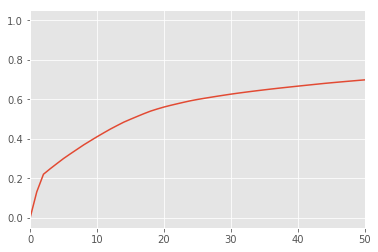

In [146]:
plt.xlim(0,50)
plt.plot(temp_index, temp_percent)

In [147]:
# Use top 20 levels to include 56% information and specify the rest levels as 'Other titles'
round(sum(loan['unique_title'].value_counts()[0:20]) / loan.shape[0], 4)

0.5609

In [148]:
top_20_levels = list(loan['unique_title'].value_counts()[0:20].index)

T_unique_title = []
for each in loan['unique_title']:
    if each in top_20_levels:
        T_unique_title.append(each)
    # Specify the rest levels as 'Other titles'
    elif each not in top_20_levels:
        T_unique_title.append('Other titles')

In [149]:
loan['T_unique_title'] = T_unique_title
print(loan.shape)

# Check if 21 levels (20 Top levels + Other titles) in T_unique_title and cover 56% information 
print(len(loan['T_unique_title'].value_counts()))
print(sum(loan['T_unique_title'].value_counts()[1:])/ loan.shape[0])

(107864, 153)
21
0.5609378476600163


In [150]:
loan = loan.drop(["unique_title", "emp_title"], axis = 1)
print(loan.shape)

(107864, 151)


#### emp_length
1. Description: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
2. NA imputation: Replace NA values with a new NA level.

In [151]:
print(loan.emp_length.isnull().sum())
print(loan.emp_length.unique())

# I decide to not collapse down the number of levels in emp_length
# It's fine to use 12 levels
print(len(loan.emp_length.unique()))

9428
['8 years' '10+ years' '1 year' '9 years' '5 years' '3 years' '6 years'
 '4 years' '2 years' nan '< 1 year' '7 years']
12


In [152]:
# NA imputation by assigning a NA level
loan.emp_length.fillna('NA_emp_length', inplace = True)

#### revol_util
1. Description: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.      
2. NA imputation: Replace NA values with the median value.

In [153]:
# revol_util should be a float type feature
print(loan['revol_util'].head())

0    37.8%
1    22.1%
2    17.8%
3    31.3%
4    47.7%
Name: revol_util, dtype: object


In [154]:
# transform revol_util into a float type feature
loan['revol_util'] = loan.revol_util.str.replace('%', '').astype('float').values
print(loan['revol_util'].head())

0    37.8
1    22.1
2    17.8
3    31.3
4    47.7
Name: revol_util, dtype: float64


In [155]:
# NA imputation (median)
print(loan['revol_util'].isnull().sum())
print(np.nanmedian(loan['revol_util']))

149
41.5


In [156]:
loan.revol_util.fillna(np.nanmedian(loan['revol_util']), inplace = True)

In [157]:
# Final check
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type of features contain NA values.')


0 categorical type of features contain NA values.


## 4 Feature transformation

- 4.1 Datetime type features transformation    
- 4.2 Features with a wrong data type
- 4.3 Categorical features with too many levels
- 4.4 Log transformation for skewed features
- 4.5 Final check

### 4.1 Datetime type features transformation
Summary: Still, there are other datetime type features needed to be deal with. They could be important features after the transformation.

#### issue_d
1. Description: The month which the loan was funded.
2. Transformation: compare itself with the maximum value (2018-03-01) in itself. (Using the same benchmark day to avoid a biased outcome.)

In [158]:
# Three unique values under T_issue_d
print(loan.T_issue_d.unique())
print(min(loan.T_issue_d))
print(max(loan.T_issue_d))

# No NA values in T_issue_d
print(loan.T_issue_d.isnull().sum())

['2018-03-01T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000']
2018-01-01 00:00:00
2018-03-01 00:00:00
0


In [159]:
# Use the maximum value 2018-03-01 as a benchmark
days_since_issue = []
for each in (pd.to_datetime('2018-03-01') - loan.T_issue_d ):
    days_since_issue.append(each.days)

In [160]:
# Make sure the output is correct
set(days_since_issue)

{0, 28, 59}

In [161]:
# Create a new column named days_since_issue in loan
loan['days_since_issue'] = days_since_issue
print(loan.shape)

(107864, 152)


In [162]:
# No clear relationship between days_since_issue & loan_status
loan.groupby(['days_since_issue', 'loan_status']).size()

days_since_issue  loan_status       
0                 Charged Off              99
                  Current               35539
                  Fully Paid             2214
                  In Grace Period         347
                  Late (16-30 days)       157
                  Late (31-120 days)      415
28                Charged Off             146
                  Current               29420
                  Fully Paid             2337
                  In Grace Period         342
                  Late (16-30 days)       136
                  Late (31-120 days)      365
59                Charged Off             275
                  Current               31870
                  Fully Paid             3158
                  In Grace Period         354
                  Late (16-30 days)       152
                  Late (31-120 days)      538
dtype: int64

In [163]:
loan['days_since_issue'].unique()

array([ 0, 28, 59])

In [164]:
level_since_issue = []
for each in loan['days_since_issue']:
    if each == 0:
        level_since_issue.append('0 mth')
    elif each == 28:
        level_since_issue.append('1 mth')
    elif each == 59:
        level_since_issue.append('2 mths')

In [165]:
# Create a new column named level_since_issue in loan
loan['level_since_issue'] = level_since_issue
print(loan.shape)
loan[['days_since_issue', 'level_since_issue']].head(10)

(107864, 153)


,days_since_issue,level_since_issue
0,0,0 mth
1,0,0 mth
2,0,0 mth
3,0,0 mth
4,0,0 mth
5,0,0 mth
6,0,0 mth
7,0,0 mth
8,0,0 mth
9,0,0 mth


#### earliest_cr_line
1. Description: The month the borrower's earliest reported credit line was opened. 
2. Transformation: compare itself with the maximum value (2018-03-01) in issue_d. (Using the maximum value in issue_d as a benchmark to compare with earliest_cr_line is reasonable because if the day difference is larger, it might indicate that a loan applicant had a long credit history before, which might further indicate that a loan applicant could fully paid a loan application with a higher probability.)    

In [166]:
loan.earliest_cr_line.head()

0    Mar-2005
1    Jan-1990
2    May-2001
3    Aug-2014
4    Dec-1994
Name: earliest_cr_line, dtype: object

In [167]:
print(loan.earliest_cr_line.unique()[0:5])
print(min(loan.earliest_cr_line))
print(max(loan.earliest_cr_line))

# No NA values in earliest_cr_line
print(loan.earliest_cr_line.isnull().sum())

['Mar-2005' 'Jan-1990' 'May-2001' 'Aug-2014' 'Dec-1994']
Apr-1963
Sep-2014
0


In [168]:
loan['T_earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])

# Drop earliest_cr_line
print(loan.shape)
loan = loan.drop('earliest_cr_line', axis = 1)
print(loan.shape)

(107864, 154)
(107864, 153)


In [169]:
# Use maximum value 2018-03-01 in T_issue_d as a benchmark
days_between_max_issue_earliest_cr_line = []
for each in (pd.to_datetime('2018-03-01') - loan.T_earliest_cr_line):
    days_between_max_issue_earliest_cr_line.append(each.days)

In [170]:
# Create a new column named days_between_max_issue_earliest_cr_line in loan
loan['days_between_max_issue_earliest_cr_line'] = days_between_max_issue_earliest_cr_line
print(loan.shape)

(107864, 154)


In [171]:
# I decided to create 10 bins
print(max(loan['days_between_max_issue_earliest_cr_line'].unique()))
print(min(loan['days_between_max_issue_earliest_cr_line'].unique()))
print((max(loan['days_between_max_issue_earliest_cr_line'].unique()) - \
     min(loan['days_between_max_issue_earliest_cr_line'].unique())) / 10)

24896
1124
2377.2


In [172]:
# The difference between each bin is 2555 days (7 years) 
level_between_max_issue_earliest_cr_line = []
for each in loan['days_between_max_issue_earliest_cr_line']:
    if each <= 2555:
        level_between_max_issue_earliest_cr_line.append('7 yrs')
    elif (each > 2555) and (each <= 5110):
        level_between_max_issue_earliest_cr_line.append('14 yrs')
    elif (each > 5110) and (each <= 7665):
        level_between_max_issue_earliest_cr_line.append('21 yrs')
    elif (each > 7665) and (each <= 10220):
        level_between_max_issue_earliest_cr_line.append('28 yrs')   
    elif (each > 10220) and (each <= 12775):
        level_between_max_issue_earliest_cr_line.append('35 yrs')
    elif (each > 12775) and (each <= 15330):
        level_between_max_issue_earliest_cr_line.append('42 yrs')   
    elif (each > 15330) and (each <= 17885):
        level_between_max_issue_earliest_cr_line.append('49 yrs')
    elif (each > 17885) and (each <= 20440):
        level_between_max_issue_earliest_cr_line.append('56 yrs')
    elif (each > 20440) and (each <= 22995):
        level_between_max_issue_earliest_cr_line.append('63 yrs')
    elif (each > 22995) and (each <= 25550):
        level_between_max_issue_earliest_cr_line.append('70 yrs')

In [173]:
set(level_between_max_issue_earliest_cr_line)

{'14 yrs',
 '21 yrs',
 '28 yrs',
 '35 yrs',
 '42 yrs',
 '49 yrs',
 '56 yrs',
 '63 yrs',
 '7 yrs',
 '70 yrs'}

In [174]:
# Create a new column named level_between_max_issue_earliest_cr_line in loan
loan['level_between_max_issue_earliest_cr_line'] = level_between_max_issue_earliest_cr_line
print(loan.shape)
loan[['days_between_max_issue_earliest_cr_line', 'level_between_max_issue_earliest_cr_line']].head(10)

(107864, 155)


,days_between_max_issue_earliest_cr_line,level_between_max_issue_earliest_cr_line
0,4748,14 yrs
1,10286,35 yrs
2,6148,21 yrs
3,1308,7 yrs
4,8491,28 yrs
5,6603,21 yrs
6,5021,14 yrs
7,6268,21 yrs
8,6056,21 yrs
9,5082,14 yrs


### 4.2 Features with a wrong data type 
1. int_rate:
    - Description: Iterest rate on the loan.
    - Transformation: Change data type from 'string' to 'float'.

In [175]:
loan['int_rate'] = loan.int_rate.str.replace('%', '').astype('float').values

In [176]:
print(loan['int_rate'].head())

0    13.58
1     6.07
2     9.43
3     7.96
4     7.34
Name: int_rate, dtype: float64


### 4.3 Categorical features with too many levels
1. addr_state:
    - Description: The state provided by the borrower in the loan application.
    - Transformation: Assign each state by west or east coast and drop zip_code column.

In [177]:
for each in loan:
    if loan[each].dtype == 'object':
        if len(loan[each].unique()) >= 10:
            print(each)
            print(loan[each].unique()[0:5])
            print(len(loan[each].unique()))
            print()

sub_grade
['C2' 'A2' 'B1' 'A5' 'A4']
35

emp_length
['8 years' '10+ years' '1 year' '9 years' '5 years']
12

purpose
['debt_consolidation' 'credit_card' 'vacation' 'other' 'home_improvement']
13

title
['Debt consolidation' 'Credit card refinancing' 'Vacation' 'Other'
 'Home improvement']
12

zip_code
['975xx' '066xx' '301xx' '147xx' '982xx']
878

addr_state
['OR' 'CT' 'GA' 'NY' 'WA']
50

level_between_max_issue_sec_earliest_cr_line
['NA yrs' '14 yrs' '21 yrs' '35 yrs' '7 yrs']
11

level_since_last_credit_pull
['Negative 4 mths' '0 mth' 'Negative 1 mth' 'Negative 2 mths' '1 mth']
10

T_unique_title
['Other titles' 'president' 'manager' 'no_emp_title' 'supervisor']
21

level_between_max_issue_earliest_cr_line
['14 yrs' '35 yrs' '21 yrs' '7 yrs' '28 yrs']
10



In [178]:
len(loan.addr_state.unique())

50

In [179]:
us_state_map = {'west': ['WA', 'OR', 'ID', 'MT', 'WY', 
                         'CA', 'NV', 'UT', 'CO',
                         'AK', 'HI'],
                'midwest': ['ND', 'SD', 'NE', 'KS', 'MN',
                            'IA', 'MO', 'WI', 'IL', 'MI',
                            'IN', 'OH'],
                'southwest': ['AZ', 'NM', 'OK', 'TX'],
                'southeast': ['KY', 'WV', 'DC', 'VA', 'AR',
                              'LA', 'TN', 'NC', 'MS', 'AL',
                              'GA', 'SC', 'FL'],
                'northeast': ['PA', 'MD', 'NY', 'VT', 'ME',
                              'NH', 'MA', 'RI', 'CT', 'NJ',
                              'DE']
               }

In [180]:
for key, value in us_state_map.items():
    print(key, value)

west ['WA', 'OR', 'ID', 'MT', 'WY', 'CA', 'NV', 'UT', 'CO', 'AK', 'HI']
midwest ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
southwest ['AZ', 'NM', 'OK', 'TX']
southeast ['KY', 'WV', 'DC', 'VA', 'AR', 'LA', 'TN', 'NC', 'MS', 'AL', 'GA', 'SC', 'FL']
northeast ['PA', 'MD', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'DE']


In [181]:
group_state = []
for each in loan.addr_state:
    for key, value in us_state_map.items():
        state_key = key
        state_values = value 
        if each in state_values:
            group_state.append(key)

In [182]:
# Make sure the length of the output
len(group_state)

107864

In [183]:
loan['group_state'] = group_state
loan = loan.drop(['addr_state','zip_code'], axis = 1)
print(loan.shape)

(107864, 154)


In [184]:
# Make sure the final output
loan['group_state'].unique()

array(['west', 'northeast', 'southeast', 'midwest', 'southwest'],
      dtype=object)

### 4.4 Log transformation for skewed features
1. Features:
    - annual_inc: The self-reported annual income provided by the borrower during registration. 
    - avg_cur_bal: Average current balance of all accounts.
    - tot_cur_bal: Total current balance of all accounts.
    - mo_sin_rcnt_tl: Months since most recent account opened.
    - mort_acc: Number of mortgage accounts.
    - mths_since_recent_bc: Months since most recent bankcard account opened.
    - tot_hi_cred_lim: Total high credit/credit limit.
    - total_bal_ex_mort: Total credit balance excluding mortgage.
    - total_bc_limit: Total bankcard high credit/credit limit.
2. Transformation: In the previoous section 'Data_Exploration', we find these features with a very skewed distribution, we perform log transformation for these feature here.   

#### annual_inc

Text(0.5,1,'Density plot: annual_inc')

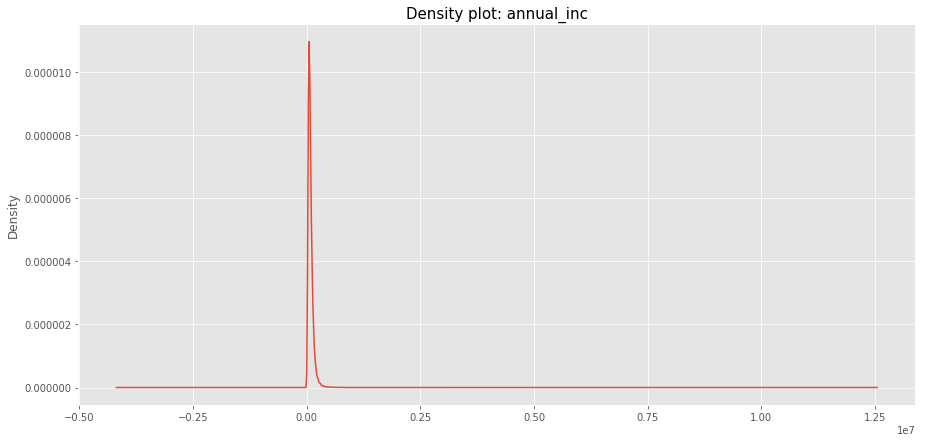

In [185]:
# plotting before log transformation
fig = plt.figure(figsize=(15,7))
loan.annual_inc.plot(kind = 'density')
plt.title('Density plot: annual_inc',fontsize=15)

In [189]:
# take log 
loan.annual_inc = np.log(loan.annual_inc + 1)

Text(0.5,1,'Density plot: annual_inc')

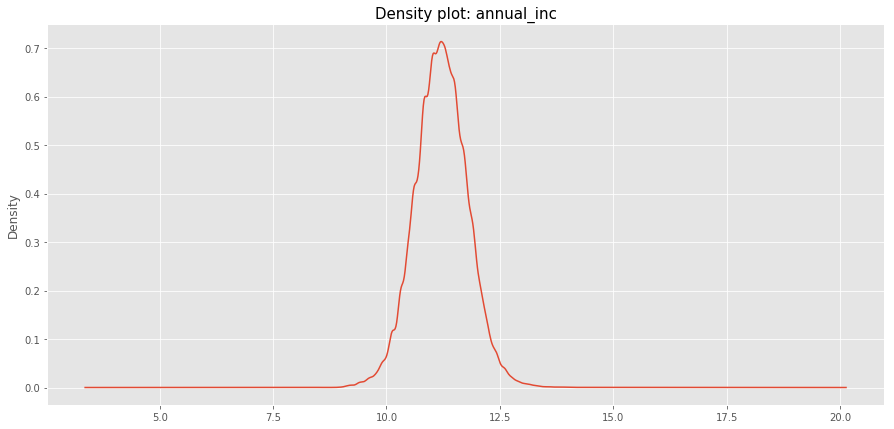

In [190]:
# plotting after log transformation, a distribution close to a normal distribution.
fig = plt.figure(figsize=(15,7))
loan.annual_inc.plot(kind = 'density')
plt.title('Density plot: annual_inc',fontsize=15)

#### for the other features 

In [191]:
skewed_features = ['avg_cur_bal', 'tot_cur_bal', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 
                   'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit']

In [192]:
# take log for skewed_features
for each in skewed_features:
    loan[each] = np.log(loan[each] + 1)

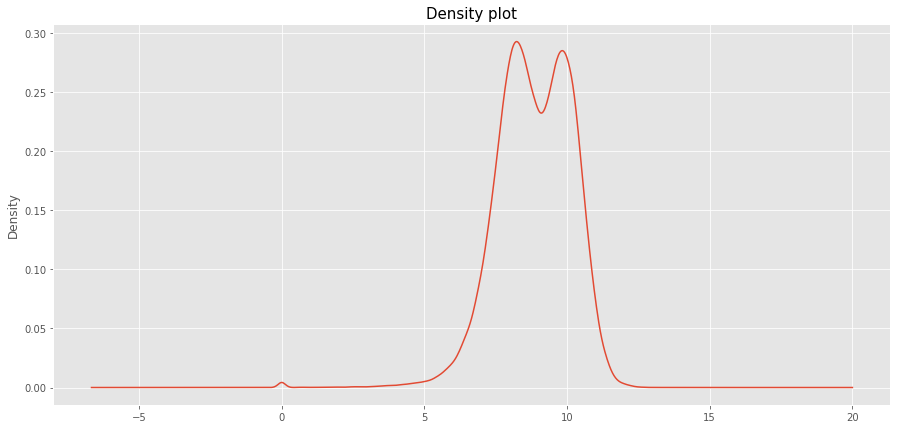

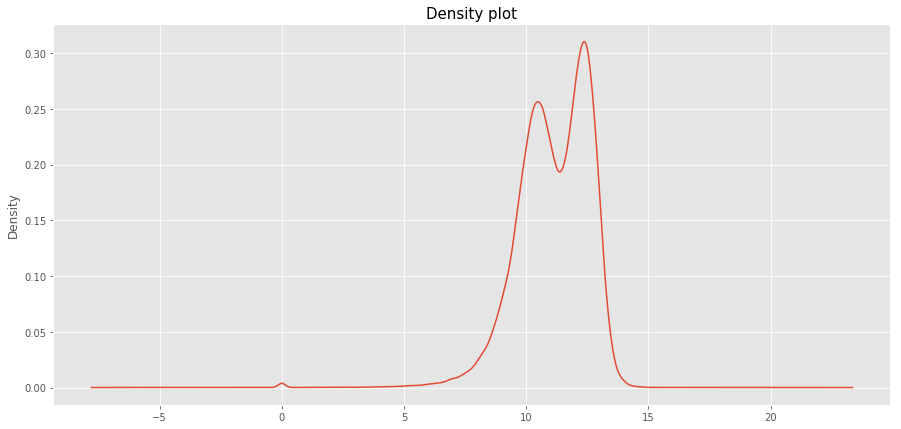

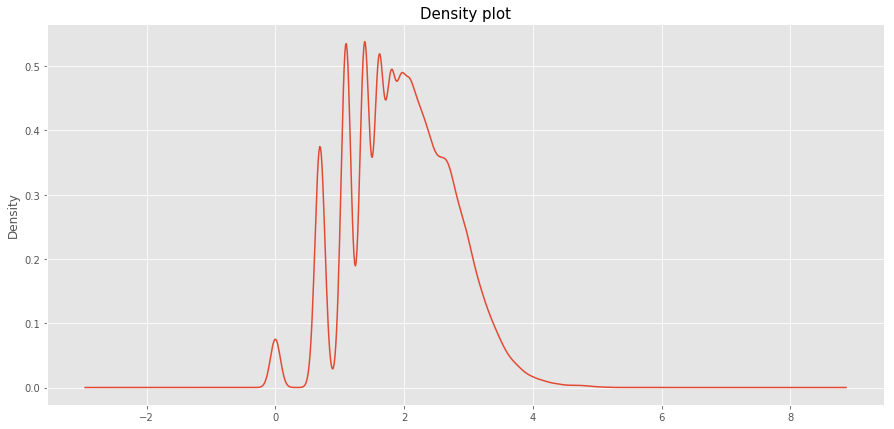

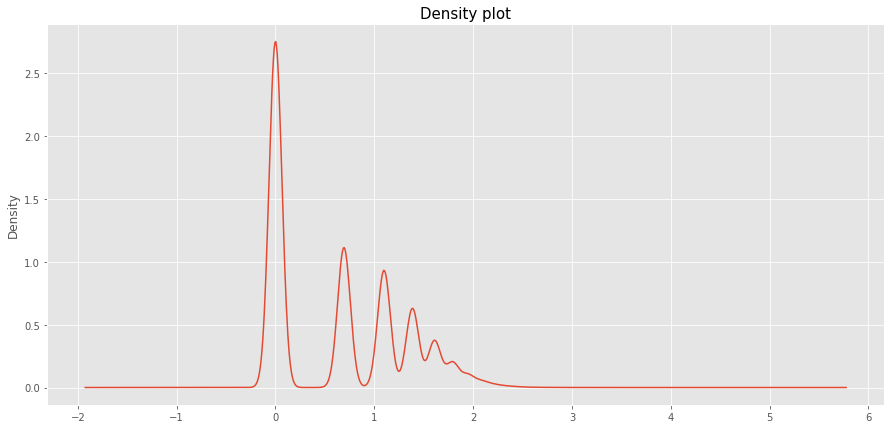

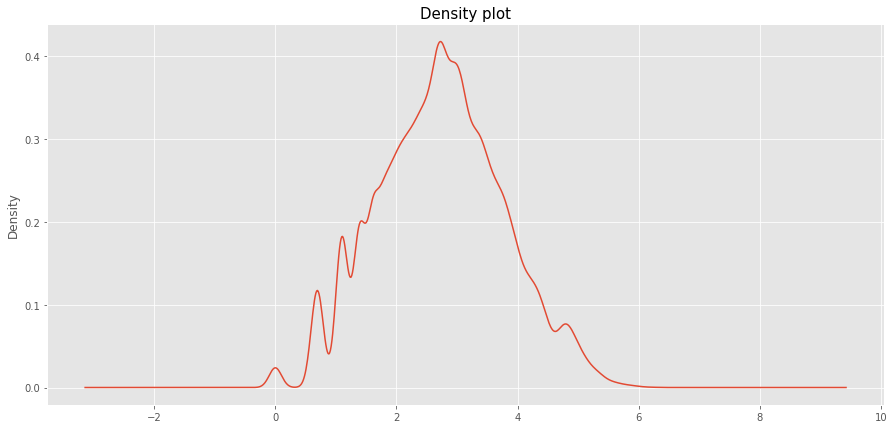

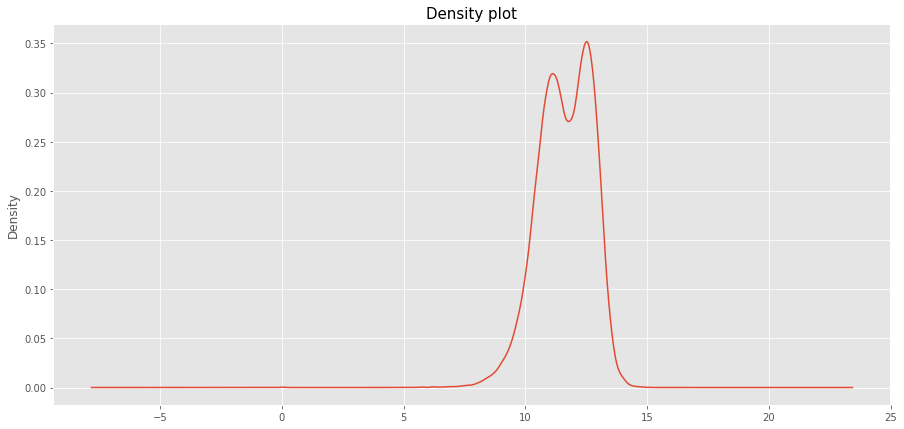

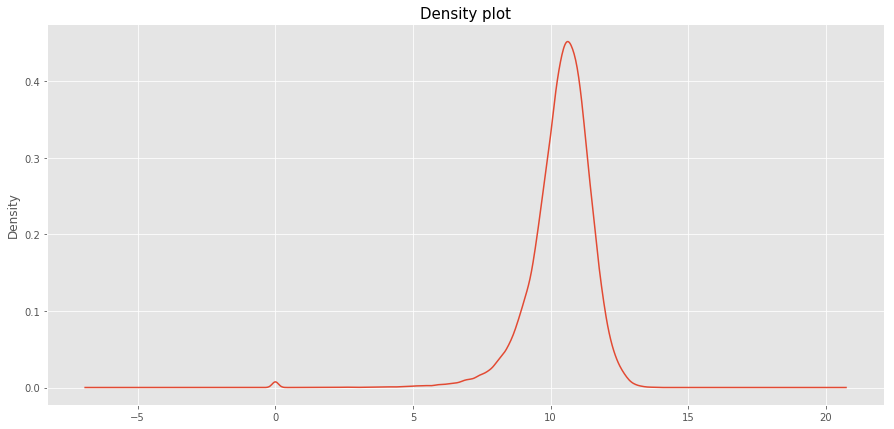

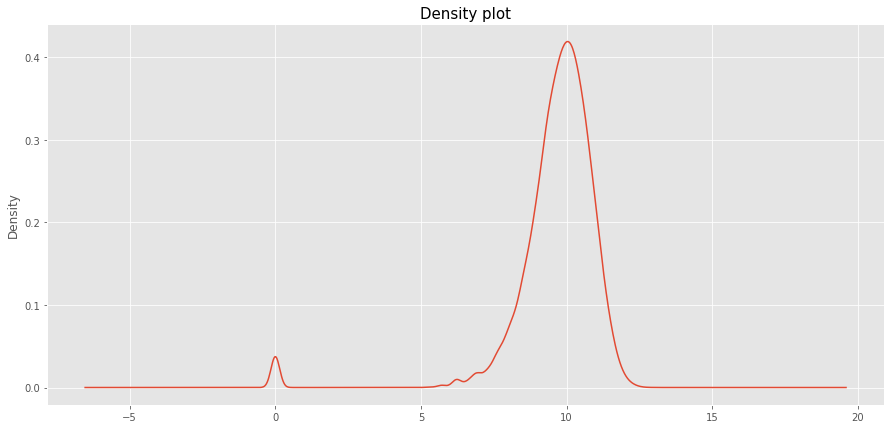

In [193]:
# check by plotting, all the distributions close to normal distribution now.
for each in skewed_features:
    fig = plt.figure(figsize=(15,7))
    loan[each].plot(kind = 'density')
    plt.title('Density plot',fontsize=15)

### 4.5 Final check

In [194]:
# Final check I: NA values
# These are variables forgot to drop after complete the transformation
drop_col = []
for each in loan:
    if loan[each].isnull().sum() != 0:
        print(each)
        drop_col.append(each)

T_payment_plan_start_date
T_hardship_start_date
T_hardship_end_date
T_settlement_date
T_sec_app_earliest_cr_line
T_last_pymnt_d
T_next_pymnt_d
T_last_credit_pull_d


In [195]:
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 146)


In [196]:
# Final check II: features with only one unique value among all records (no prediction power)
drop_col = []
for each in loan:
    if len(loan[each].unique()) == 1:
        print(each)
        drop_col.append(each)

policy_code
num_tl_120dpd_2m


In [197]:
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 144)


In [198]:
# Final check III: manually scan the data type & columns forgot to drop
for each in loan:
    print(loan[each].head())
    print('-------------------------------')

0     7200.0
1    12000.0
2     3100.0
3     3200.0
4    11000.0
Name: loan_amnt, dtype: float64
-------------------------------
0     7200.0
1    12000.0
2     3100.0
3     3200.0
4    11000.0
Name: funded_amnt, dtype: float64
-------------------------------
0     7200.0
1    12000.0
2     3100.0
3     3200.0
4    11000.0
Name: funded_amnt_inv, dtype: float64
-------------------------------
0     36 months
1     36 months
2     36 months
3     36 months
4     36 months
Name: term, dtype: object
-------------------------------
0    13.58
1     6.07
2     9.43
3     7.96
4     7.34
Name: int_rate, dtype: float64
-------------------------------
0    244.62
1    365.45
2     99.21
3    100.22
4    341.37
Name: installment, dtype: float64
-------------------------------
0    C
1    A
2    B
3    A
4    A
Name: grade, dtype: object
-------------------------------
0    C2
1    A2
2    B1
3    A5
4    A4
Name: sub_grade, dtype: object
-------------------------------
0      8 years
1    10+ ye

In [199]:
drop_col = ['issue_d', 'T_issue_d', 'T_earliest_cr_line']
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 141)


## 5 Outliers imputation
- reference (three ways of outlier detectation): http://colingorrie.github.io/outlier-detection.html

In [200]:
# function of detecting outliers
def outliers_iqr(input_data):
    quartile_1, quartile_3 = np.percentile(input_data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.array(np.where((input_data > upper_bound) | (input_data < lower_bound))).flatten()

In [201]:
# function of detecting outliers
def outliers_iqr_I(input_data):
    quartile_1, quartile_3 = np.percentile(input_data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.array(np.where(input_data > upper_bound)).flatten(),\
np.array(np.where(input_data < lower_bound)).flatten(), upper_bound, lower_bound

In [202]:
# collect names of numerical type of features
num_col = []
for each in loan:
    if loan[each].dtype != 'object':
        num_col.append(each)
print(len(num_col))

109


In [203]:
# notice that we must remove 'loan_status_binary' from the num_col
# otherwise, we will do outlier imputation on this column too
num_col.remove('loan_status_binary')

In [204]:
# collect names of numerical type of features containing outliers
outlier_num_col = []
for each in num_col:
    if len(outliers_iqr(loan[each])) != 0:
        outlier_num_col.append(each)

In [205]:
# 101 numerical type of features containing outliers
len(outlier_num_col)

101

In [206]:
# outlier imputation (capping)
for each in outlier_num_col:
    loan[each][outliers_iqr_I(loan[each])[0]] = outliers_iqr_I(loan[each])[2]
    loan[each][outliers_iqr_I(loan[each])[1]] = outliers_iqr_I(loan[each])[3]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [207]:
# make sure finish outlier imputation 
for each in outlier_num_col:
    if len(outliers_iqr_I(loan[each])[0]) != 0:
        print(each)

## 6. Feature selection by feature significance
### 6.1 Numerical type of features: using t-test
- t-test documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- 6.1.1 Distribution visualization using top 10 numerical type of features
- 6.1.2 Heatmap of correlations (top 10 numerical type of features VS loan_status_binary)


### 6.2 Categorical type of features: using chi-square test
- chi-square test documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

### 6.1 Numerical type of features: using t-test

In [208]:
# Notice: after NA imputation, 42 numerical features only contain one unique value
# These numerical features should be dropped when performing a t-test & calculating correlation
i = 0
drop_col = []

for each in loan.columns:
    if loan[each].dtype != 'object':
        if len(loan[each].unique()) == 1:
            drop_col.append(each)
            i += 1
i

42

In [209]:
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 99)


In [210]:
cate_col = []
num_col = []
for each in loan:
    if loan[each].dtype == 'object':
        cate_col.append(each)
    else: 
        num_col.append(each)

In [211]:
# Make sure the for loop selected every column
len(cate_col) + len(num_col) == loan.shape[1]

True

In [212]:
# Function of performing a two-sided t-test (unequal variance between two groups)
def num_feature_significance(col_name):
    p_value = stats.ttest_ind(loan[loan['loan_status_binary'] == 0][col_name],
               loan[loan['loan_status_binary'] == 1][col_name],
                              equal_var=False,
                              nan_policy='omit')[1]
    return p_value

In [213]:
# Perform the t-test for each numerical feature
all_p_value = []
for each in num_col:
    all_p_value.append(num_feature_significance(each))

In [214]:
i = 0
j = 0
for col_name, p_value in list(zip(num_col, all_p_value)):
    if p_value < 0.05:
        i += 1

for col_name, p_value in list(zip(num_col, all_p_value)):
    if p_value < 0.01:
        j += 1

In [215]:
print('Originally I have',len(num_col),'numerical type of features.')
print(i,'numerical type of features passed 0.05 threshold.')
print(j,'numerical type of features passed 0.01 threshold.')
print(len(num_col) - i,'numerical type of features not passed 0.05 threshold.')

Originally I have 67 numerical type of features.
62 numerical type of features passed 0.05 threshold.
59 numerical type of features passed 0.01 threshold.
5 numerical type of features not passed 0.05 threshold.


In [216]:
# Find the top 10 numerical type of features by sorting the p-values
np.argsort(all_p_value)[1:11]

array([63, 62, 14, 15,  3,  7, 60, 37, 31, 45])

In [217]:
tem_col_name = []
for each in [16, 62, 14, 15,  3,  7, 60, 37, 31, 45]:
    tem_col_name.append(num_col[each])

print(len(tem_col_name))
print(tem_col_name)

10
['total_rec_prncp', 'loan_status_binary', 'total_pymnt', 'total_pymnt_inv', 'int_rate', 'inq_last_6mths', 'total_bc_limit', 'bc_open_to_buy', 'total_rev_hi_lim', 'mths_since_recent_inq']


### 6.1.1 Distribution visualization using top 10 numerical type of features

In [218]:
# Function of visualization
def num_feature_distribution_plot(col_name):
    plt.figure(figsize = (10, 8))

    # KDE plot of loan_status_binary is 0 
    sns.kdeplot(loan.loc[loan['loan_status_binary'] == 0, col_name], label = 'target == 0')

    # KDE plot of loan_status_binary is 1 (either Current or Fully Paid)
    sns.kdeplot(loan.loc[loan['loan_status_binary'] == 1, col_name], label = 'target == 1')

    # Labeling of plot
    plt.xlabel(col_name)
    plt.title('Distribution of '+ col_name)

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


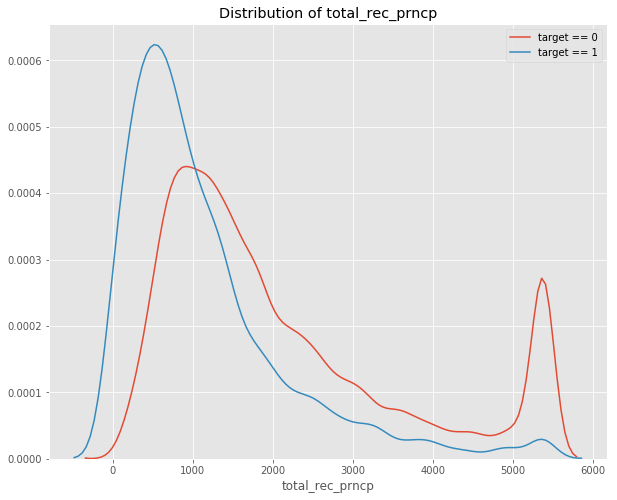

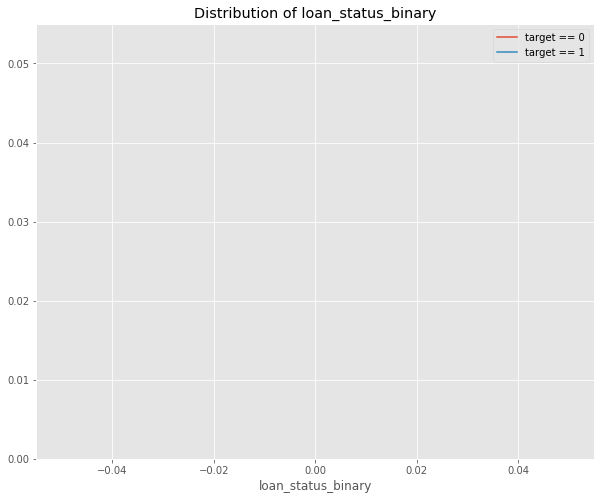

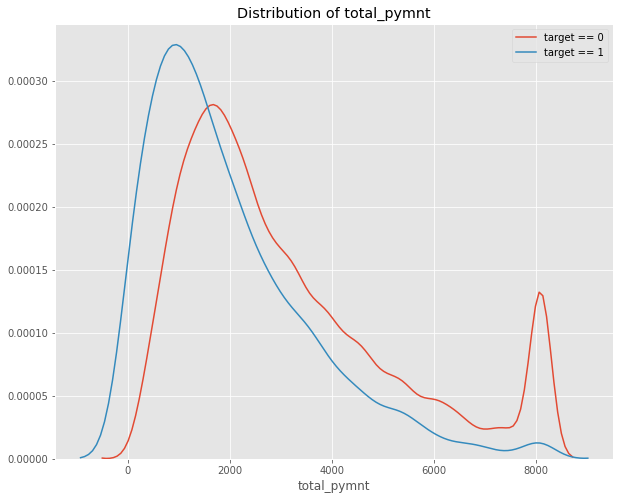

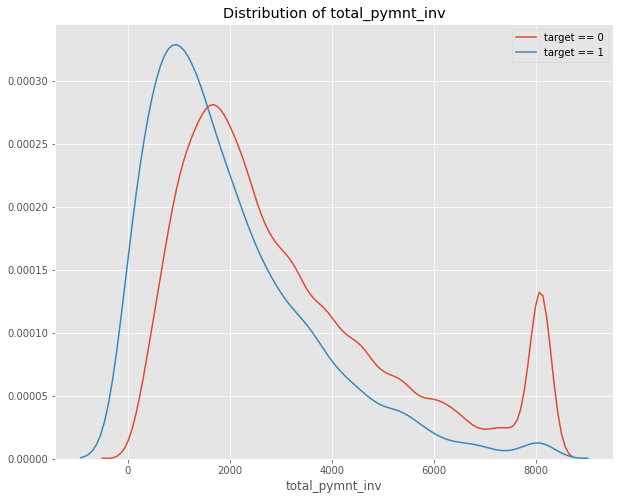

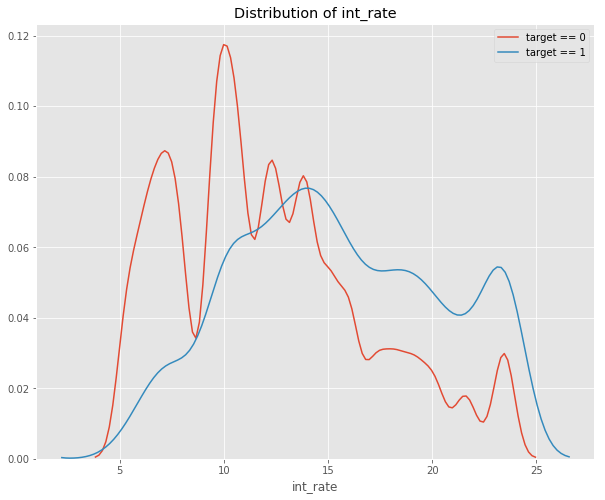

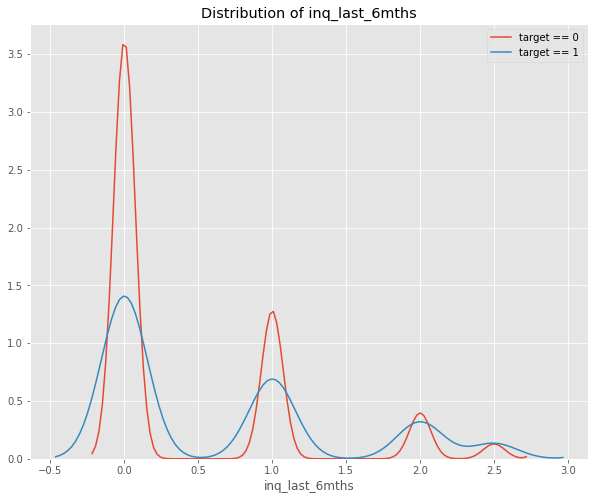

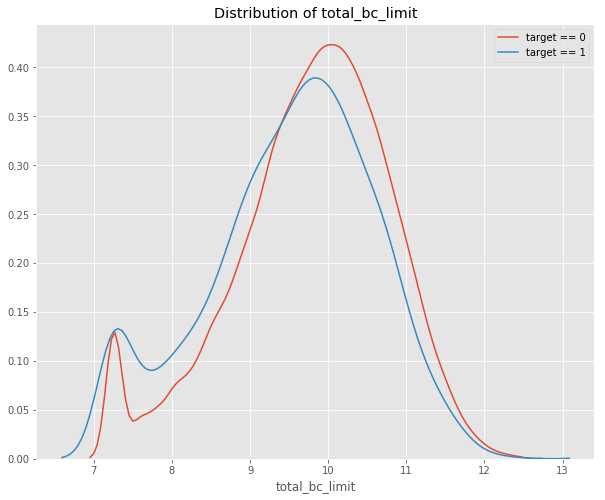

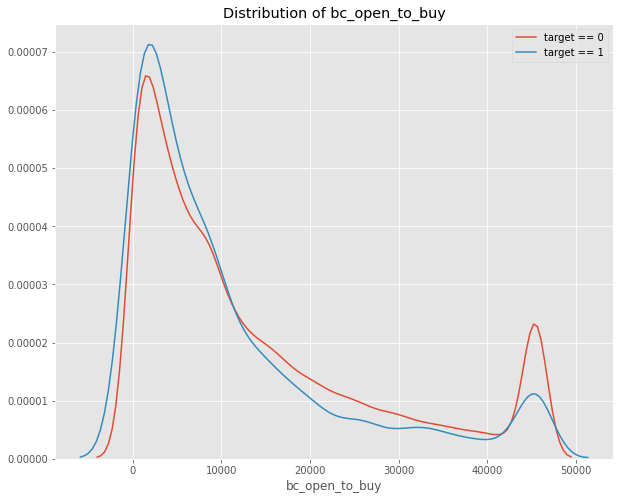

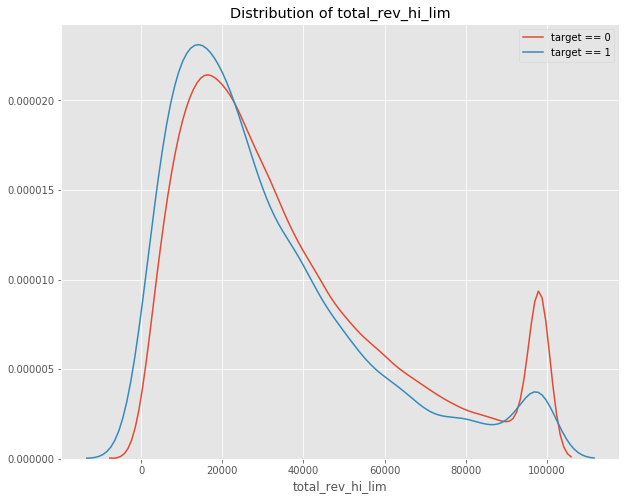

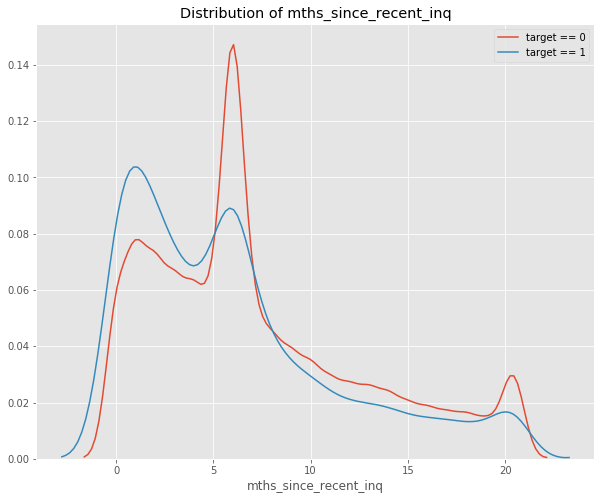

In [219]:
for each in tem_col_name:
    num_feature_distribution_plot(each)

#### 6.1.2 Heatmap of correlations (top 10 numerical type of features VS loan_status_binary)
- sns.heatmap documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [220]:
tem_col_name.append('loan_status_binary')

In [221]:
top_ten_num_col_corr = loan[tem_col_name].corr()
top_ten_num_col_corr

,total_rec_prncp,loan_status_binary,total_pymnt,total_pymnt_inv,int_rate,inq_last_6mths,total_bc_limit,bc_open_to_buy,total_rev_hi_lim,mths_since_recent_inq,loan_status_binary
total_rec_prncp,1.000000,-0.110602,0.946089,0.946014,-0.177955,-0.004707,0.276678,0.215253,0.284029,-0.010014,-0.110602
loan_status_binary,-0.110602,1.000000,-0.093321,-0.093309,0.119266,0.052371,-0.047323,-0.034562,-0.035256,-0.036020,1.000000
total_pymnt,0.946089,-0.093321,1.000000,0.999996,0.041667,0.013950,0.251840,0.154864,0.259952,-0.026551,-0.093321
total_pymnt_inv,0.946014,-0.093309,0.999996,1.000000,0.041791,0.013910,0.251872,0.154907,0.259989,-0.026524,-0.093309
int_rate,-0.177955,0.119266,0.041667,0.041791,1.000000,0.134573,-0.289616,-0.396003,-0.273101,-0.089791,0.119266
inq_last_6mths,-0.004707,0.052371,0.013950,0.013910,0.134573,1.000000,0.008261,0.044062,0.039151,-0.547572,0.052371
total_bc_limit,0.276678,-0.047323,0.251840,0.251872,-0.289616,0.008261,1.000000,0.738542,0.813554,0.006315,-0.047323
bc_open_to_buy,0.215253,-0.034562,0.154864,0.154907,-0.396003,0.044062,0.738542,1.000000,0.754393,-0.037766,-0.034562
total_rev_hi_lim,0.284029,-0.035256,0.259952,0.259989,-0.273101,0.039151,0.813554,0.754393,1.000000,-0.020244,-0.035256
mths_since_recent_inq,-0.010014,-0.036020,-0.026551,-0.026524,-0.089791,-0.547572,0.006315,-0.037766,-0.020244,1.000000,-0.036020


Text(0.5,1,'Correlation Heatmap')

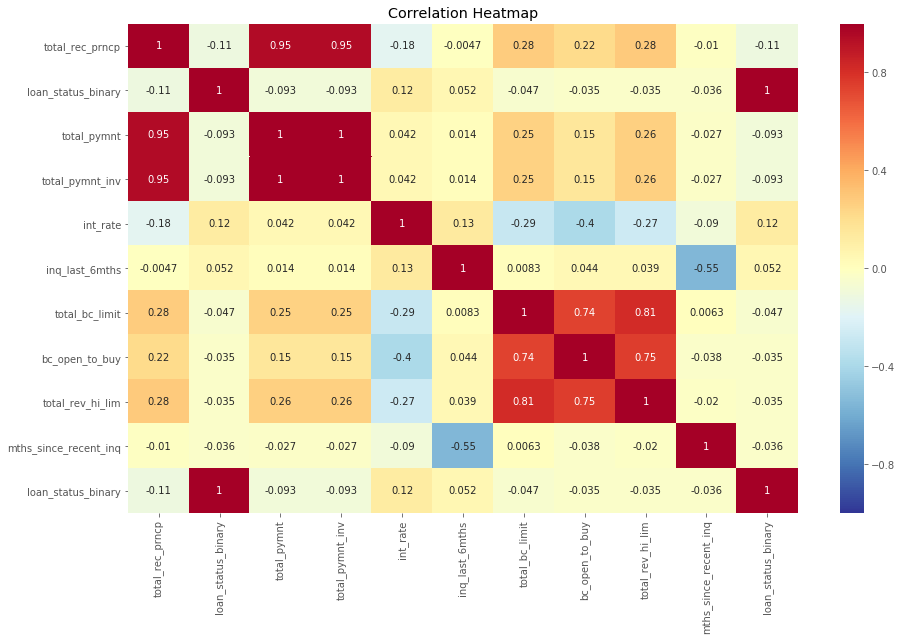

In [222]:
# Some multicollinearity between some features
plt.figure(figsize = (15, 9))

sns.heatmap(top_ten_num_col_corr, cmap = plt.cm.RdYlBu_r, vmin = -1, annot = True, vmax = 1)
plt.title('Correlation Heatmap')

In [223]:
print(len(num_col))
print(len(all_p_value))

67
67


In [224]:
# collect rank in correlation and feature significance
num_feat_selection = pd.DataFrame({'name':num_col,
                                   'p_value':all_p_value,
                                   'correlation':loan[num_col].corr()['loan_status_binary'].values})

In [225]:
num_feat_selection[num_feat_selection['name'] == 'loan_status_binary']

,name,p_value,correlation
62,loan_status_binary,0.0,1.0


In [226]:
# attain top 10 numerical features by sorting out top 10 smallest p values
num_feat_selection.iloc[np.argsort(all_p_value)[1:11]]

,name,p_value,correlation
63,numeric_diff_last_issue_d,0.000000e+00,-0.210116
62,loan_status_binary,0.000000e+00,1.000000
14,total_pymnt,1.077488e-285,-0.093321
15,total_pymnt_inv,1.173527e-285,-0.093309
3,int_rate,1.846501e-261,0.119266
7,inq_last_6mths,1.675268e-47,0.052371
60,total_bc_limit,4.885164e-47,-0.047323
37,bc_open_to_buy,9.046658e-35,-0.034562
31,total_rev_hi_lim,1.810938e-34,-0.035256
45,mths_since_recent_inq,1.919064e-32,-0.036020


In [227]:
# attain top 10 numerical features by sorting out top 10 absolute correlations
num_feat_selection.iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][1:11]]

,name,p_value,correlation
63,numeric_diff_last_issue_d,0.000000e+00,-0.210116
3,int_rate,1.846501e-261,0.119266
16,total_rec_prncp,0.000000e+00,-0.110602
14,total_pymnt,1.077488e-285,-0.093321
15,total_pymnt_inv,1.173527e-285,-0.093309
7,inq_last_6mths,1.675268e-47,0.052371
60,total_bc_limit,4.885164e-47,-0.047323
34,inq_last_12m,4.945035e-32,0.039172
45,mths_since_recent_inq,1.919064e-32,-0.036020
31,total_rev_hi_lim,1.810938e-34,-0.035256


In [228]:
loan[num_col].corr()['loan_status_binary'].\
                   iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][0:10]].index

Index(['loan_status_binary', 'numeric_diff_last_issue_d', 'int_rate',
       'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv', 'inq_last_6mths',
       'total_bc_limit', 'inq_last_12m', 'mths_since_recent_inq'],
      dtype='object')

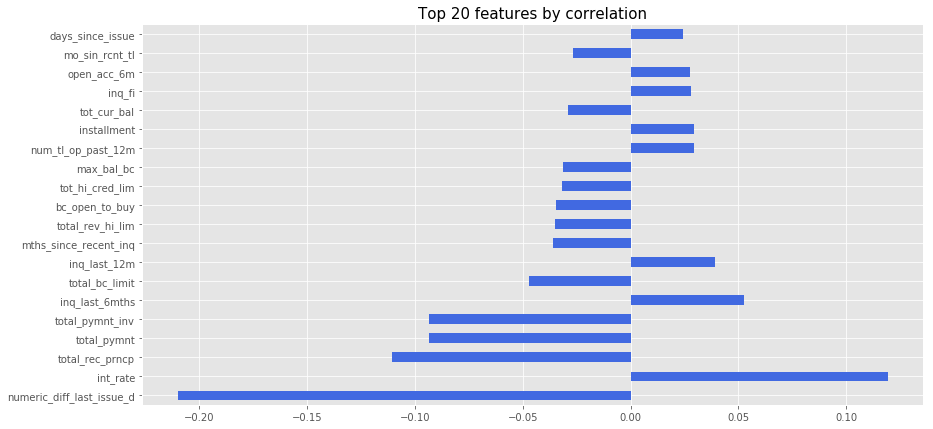

In [229]:
# bar chart plot of coefficients of features

# set plot size
fig = plt.figure(figsize=(14,7))

# bar chart
ax = loan[num_col].corr()['loan_status_binary'].\
iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][1:21]].plot.barh(color = 'royalblue')

# y ticks, y lables, and title name
t = np.arange(20)
ax.set_yticks(t)
ax.set_yticklabels(loan[num_col].corr()['loan_status_binary'].\
                   iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][1:21]].index)
plt.title('Top 20 features by correlation',fontsize=15)

plt.show()

### 6.2 Categorical type of features: using chi-square test

In [230]:
cate_col[0:5]

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership']

In [231]:
def cate_feature_significance(col_name):
    # collect row sum
    row_sum_1 = sum(loan[loan.loan_status_binary == 0][col_name].value_counts())
    row_sum_2 = sum(loan[loan.loan_status_binary == 1][col_name].value_counts())
    
    total_sum = row_sum_1 + row_sum_2
    
    # collect column sum by each index
    index_name = []
    for name in loan[col_name].unique():
        index_name.append(name)
    
    col_sum = []    
    for name in index_name:
        col_sum.append(loan[loan.loan_status_binary == 0][col_name].value_counts()[name] + \
                       loan[loan.loan_status_binary == 1][col_name].value_counts()[name])
        
    if len(col_sum) == len(index_name):
    
        # collect original values
        original_values = []
        for each in index_name:
            original_values.append(loan[loan.loan_status_binary == 0][col_name].value_counts()[each])
        for each in index_name:
            original_values.append(loan[loan.loan_status_binary == 1][col_name].value_counts()[each])
            
        # collect expected values
        expected_values = []
        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_1) / total_sum)
            
        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_2) / total_sum)
        
        # perform chi-square test
        degree_of_freedom = len(index_name) - 1
        p_value = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[1]
        chi_square_statistic = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[0]
        return p_value, chi_square_statistic, original_values, expected_values
        
    elif len(col_sum) != len(index_name):
        print('error occurred', col_name)

In [232]:
def cate_feature_significance_I(col_name):
    
    loan_status_binary_0 = loan[loan.loan_status_binary == 0][col_name].value_counts()
    loan_status_binary_1 = loan[loan.loan_status_binary == 1][col_name].value_counts()
    
    # collect row sum
    row_sum_1 = sum(loan_status_binary_0)
    row_sum_2 = sum(loan_status_binary_1)
    
    total_sum = row_sum_1 + row_sum_2
    
    # collect column sum by each index
    index_name = [name for name in loan[col_name].unique()]
    
    col_sum = []
    for name in index_name:
        if name in loan_status_binary_0.index:
            col_0 = loan_status_binary_0[name]
        elif name not in loan_status_binary_0.index:
            col_0 = 0
        if name in loan_status_binary_1.index:
            col_1 = loan_status_binary_1[name]
        elif name not in loan_status_binary_1.index:
            col_1 = 0
        col_sum.append(col_0 + col_1)
        
    if len(col_sum) == len(index_name):
        # collect original values
        original_values = []

        for name in index_name:
            if name in loan_status_binary_0.index:
                col_0 = loan_status_binary_0[name]
            elif name not in loan_status_binary_0.index:
                col_0 = 0
            original_values.append(col_0)

        for name in index_name:        
            if name in loan_status_binary_1.index:
                col_1 = loan_status_binary_1[name]
            elif name not in loan_status_binary_1.index:
                col_1 = 0
            original_values.append(col_1)
        
        # collect expected values
        expected_values = []
        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_1) / total_sum)

        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_2) / total_sum)

        # perform chi-square test
        degree_of_freedom = len(index_name) - 1
        p_value = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[1]
        chi_square_statistic = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[0]
        return p_value, chi_square_statistic, original_values, expected_values
        
    elif len(col_sum) != len(index_name):
        print('error occurred', col_name)

#### manually test few categorical features to check whether the outputs from cate_feature_significance() is correct

#### Test on 'term'

In [233]:
loan.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [234]:
# original cell values
print('loan_status_binary == 0:')
print(loan[loan.loan_status_binary == 0]['term'].value_counts())
print()
print('loan_status_binary == 1:')
print(loan[loan.loan_status_binary == 1]['term'].value_counts())

loan_status_binary == 0:
 36 months    73361
 60 months    31177
Name: term, dtype: int64

loan_status_binary == 1:
 36 months    2051
 60 months    1275
Name: term, dtype: int64


In [235]:
# row sum
print('loan_status_binary == 0:', sum(loan[loan.loan_status_binary == 0]['term'].value_counts()))
print('loan_status_binary == 1:', sum(loan[loan.loan_status_binary == 1]['term'].value_counts()))

loan_status_binary == 0: 104538
loan_status_binary == 1: 3326


In [236]:
# column sum
print('36 months: loan_status_binary == 0 + loan_status_binary == 1')
print(loan[loan.loan_status_binary == 0]['term'].value_counts()[0] + \
      loan[loan.loan_status_binary == 1]['term'].value_counts()[0])
print('60 months: loan_status_binary == 0 + loan_status_binary == 1')
print(loan[loan.loan_status_binary == 0]['term'].value_counts()[1] + \
      loan[loan.loan_status_binary == 1]['term'].value_counts()[1])

36 months: loan_status_binary == 0 + loan_status_binary == 1
75412
60 months: loan_status_binary == 0 + loan_status_binary == 1
32452


In [237]:
# total sum
print('loan_status_binary == 0 + loan_status_binary == 1: ', 
sum(loan[loan.loan_status_binary == 0]['term'].value_counts()) + \
sum(loan[loan.loan_status_binary == 1]['term'].value_counts()))

loan_status_binary == 0 + loan_status_binary == 1:  107864


In [238]:
# manual results
# compare original values, expected values, chi-square test statistic, and p-value
a = [2051, 1275, 73361, 31177]
b = [75412*104538/107864, 32452*104538/107864, 75412*3326/107864, 32452*3326/107864]
b

[73086.66149966624, 31451.338500333753, 2325.3385003337535, 1000.6614996662464]

In [239]:
stats.chisquare(a,b, len(loan.term.unique()) - 1)

Power_divergenceResult(statistic=3178039.3646629793, pvalue=0.0)

In [240]:
# function results, are the same to the manual results
start_time = time.time()
print(cate_feature_significance_I('term'))
print('execution time:',time.time() - start_time)

(7.880599009025661e-25, 111.00044681499328, [73361, 31177, 2051, 1275], [73086.66149966624, 31451.338500333753, 2325.3385003337535, 1000.6614996662464])
execution time: 0.08787202835083008


#### Test on 'grade'

In [241]:
loan.grade.unique()

array(['C', 'A', 'B', 'E', 'D', 'G', 'F'], dtype=object)

In [242]:
# original cell values
print(loan[loan.loan_status_binary == 0]['grade'].value_counts())
print()
print(loan[loan.loan_status_binary == 1]['grade'].value_counts())

B    31789
C    27713
A    26498
D    14476
E     3362
F      596
G      104
Name: grade, dtype: int64

C    1034
D     901
B     693
E     329
A     271
F      86
G      12
Name: grade, dtype: int64


In [243]:
# row sum
print(sum(loan[loan.loan_status_binary == 0]['grade'].value_counts()))
print(sum(loan[loan.loan_status_binary == 1]['grade'].value_counts()))

104538
3326


In [244]:
# column sum
print(loan[loan.loan_status_binary == 0]['grade'].value_counts()[0] + \
      loan[loan.loan_status_binary == 1]['grade'].value_counts()[0])

print(loan[loan.loan_status_binary == 0]['grade'].value_counts()[1] + \
      loan[loan.loan_status_binary == 1]['grade'].value_counts()[1])

32823
28614


In [245]:
# total sum
sum(loan[loan.loan_status_binary == 0]['grade'].value_counts()) + \
sum(loan[loan.loan_status_binary == 1]['grade'].value_counts())

107864

In [246]:
# manual results
# compare original values, expected values, chi-square test statistic, and p-value
a = [271, 693, 1034, 901, 329, 86, 12, 26498, 31789, 27713, 14476, 3362, 596, 104]

b = [28747*104538/107864, 26769*104538/107864, 32482*104538/107864, 3691*104538/107864, 15377*104538/107864, 116*104538/107864, 682*104538/107864,
    28747*3326/107864, 26769*3326/107864, 32482*3326/107864, 3691*3326/107864, 15377*3326/107864, 116*3326/107864, 682*3326/107864]

In [247]:
b

[27860.58264110361,
 25943.574519765632,
 31480.41344656234,
 3577.1875509901356,
 14902.848271897945,
 112.42312541719203,
 660.9704442631462,
 886.417358896388,
 825.4254802343692,
 1001.5865534376622,
 113.81244900986427,
 474.15172810205445,
 3.57687458280798,
 21.029555736853816]

In [248]:
stats.chisquare(a,b, len(loan.grade.unique()) - 1)

Power_divergenceResult(statistic=4640554.803509146, pvalue=0.0)

In [249]:
# function results, are the same to the manual results
start_time = time.time()
print(cate_feature_significance_I('grade'))
print('execution time:',time.time() - start_time)

(0.0, 1551.5723760682592, [27713, 26498, 31789, 3362, 14476, 104, 596, 1034, 271, 693, 329, 901, 12, 86], [27860.58264110361, 25943.574519765632, 31480.41344656234, 3577.1875509901356, 14902.848271897945, 112.42312541719203, 660.9704442631462, 886.417358896388, 825.4254802343692, 1001.5865534376622, 113.81244900986427, 474.15172810205445, 3.57687458280798, 21.029555736853816])
execution time: 0.12405586242675781


In [250]:
cate_feat_all_p = []
for each in cate_col:
    cate_feat_all_p.append(cate_feature_significance_I(each)[0])

In [251]:
len(cate_feat_all_p)

32

In [252]:
i = 0
j = 0
for p_value in cate_feat_all_p:
    if p_value < 0.05:
        i += 1
for p_value in cate_feat_all_p:
    if p_value < 0.01:
        j += 1

In [253]:
print('Originally I have',len(cate_col),'categorical type of features.')
print(i,'categorical type of features passed 0.05 threshold.')
print(j,'categorical type of features passed 0.01 threshold.')
print(len(cate_col) - i,'categorical type of features not passed 0.05 threshold.')

Originally I have 32 categorical type of features.
32 categorical type of features passed 0.05 threshold.
32 categorical type of features passed 0.01 threshold.
0 categorical type of features not passed 0.05 threshold.


In [254]:
pd.DataFrame({'name':cate_col,
             'p_value': cate_feat_all_p})

,name,p_value
0,term,7.880599e-25
1,grade,0.000000e+00
2,sub_grade,0.000000e+00
3,emp_length,2.478085e-08
4,home_ownership,5.656187e-13
5,verification_status,7.792165e-52
6,loan_status,0.000000e+00
7,pymnt_plan,2.236834e-14
8,purpose,5.663910e-37
9,title,9.968293e-37


### 6.2.1 Distribution visualization using top 10 categorical type of features

In [255]:
# Find the top 10 categorical type of features by sorting the p-values
np.argsort(cate_feat_all_p)[1:11]

array([ 2, 25,  6, 19, 18, 23, 26,  5,  8,  9])

In [256]:
tem_col_name = []
for each in [24,  2,  1, 22, 17, 18,  5,  7,  8, 25]:
    tem_col_name.append(cate_col[each])

print(len(tem_col_name))
print(tem_col_name)

10
['level_between_max_issue_sec_earliest_cr_line', 'sub_grade', 'grade', 'days_between_issue_hardship_end_date', 'disbursement_method', 'debt_settlement_flag', 'verification_status', 'pymnt_plan', 'purpose', 'level_diff_last_issue_d']


In [257]:
def cate_feature_distribution_plot(col_name):
    
    loan_status_binary_0 = loan[loan.loan_status_binary == 0][col_name].value_counts()
    loan_status_binary_1 = loan[loan.loan_status_binary == 1][col_name].value_counts()
    
    index_name = [name for name in loan[col_name].unique()]
    index_name = sorted(index_name)
    value_status_0 = []
    for name in index_name:
        if name in loan_status_binary_0.index:
            tem_value = loan_status_binary_0[name]
        elif name not in loan_status_binary_0.index:
            tem_value = 0
            
        value_status_0.append(tem_value)
        
    value_status_1 = []    
    for name in index_name:
        if name in loan_status_binary_1.index:
            tem_value = loan_status_binary_1[name]
        elif name not in loan_status_binary_1.index:
            tem_value = 0
            
        value_status_1.append(tem_value)
        
    fig = plt.figure(figsize=(14,7))    
    ind = np.arange(len(index_name)) 
    p1 = plt.bar(ind, value_status_0, color='r', alpha = 0.4)
    p2 = plt.bar(ind, value_status_1, color='b', alpha = 0.4)
    
    plt.title('Distribution of ' + col_name)
    plt.xticks(ind, index_name, rotation='vertical')
    plt.legend((p1[0], p2[0]), ('loan status: 0', 'loan status: 1'))
    #return value_status_0, value_status_1

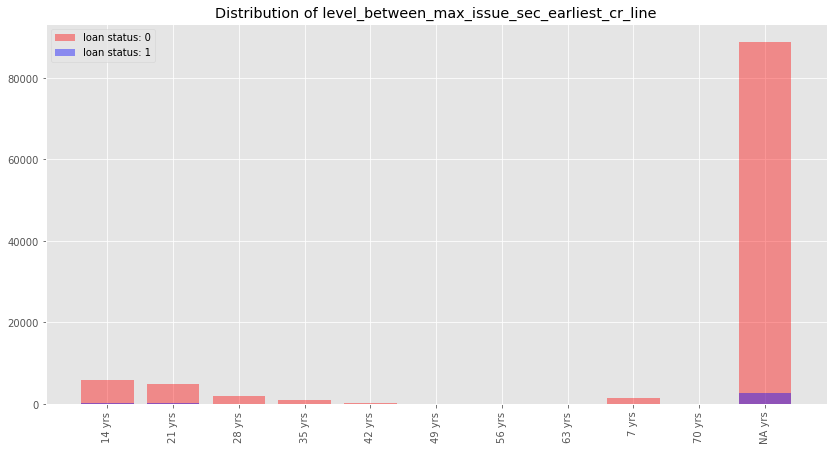

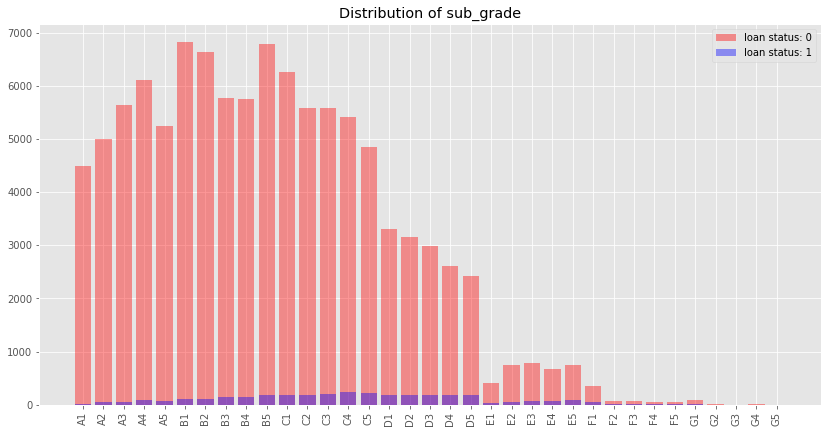

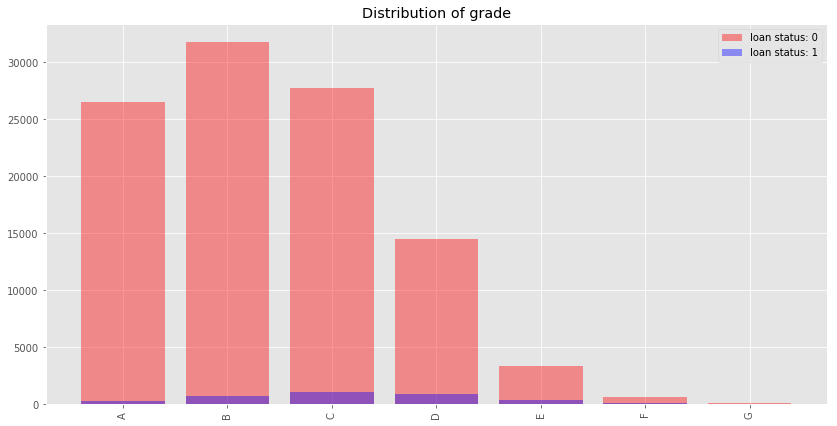

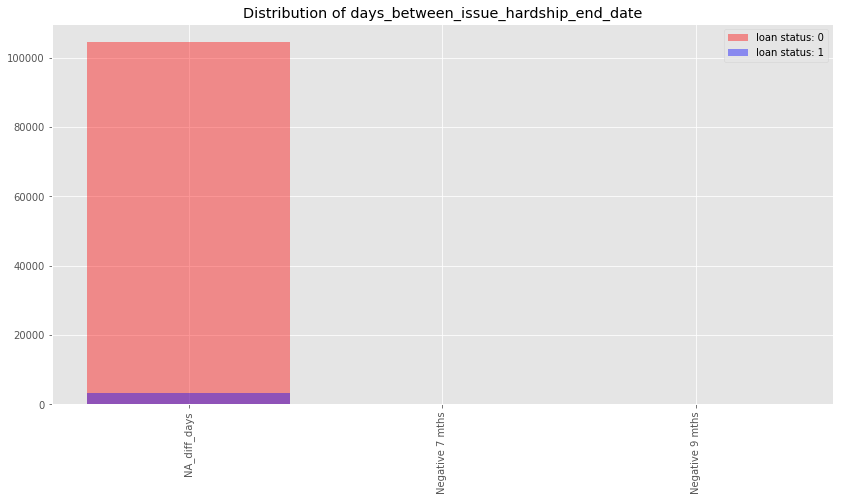

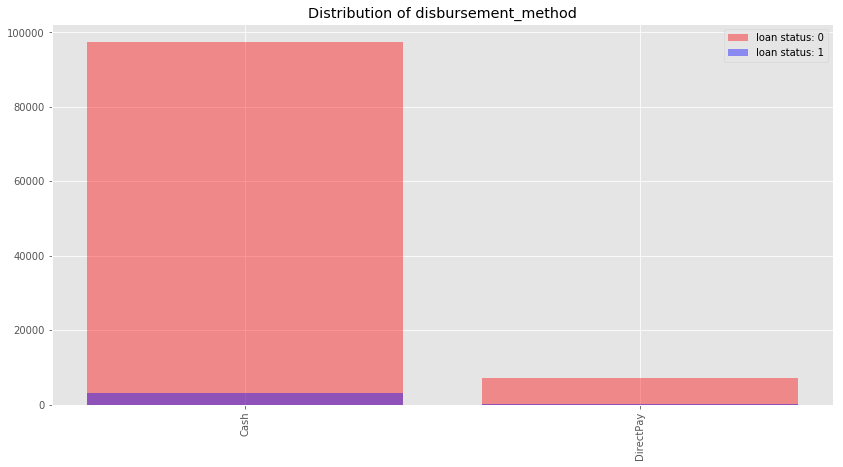

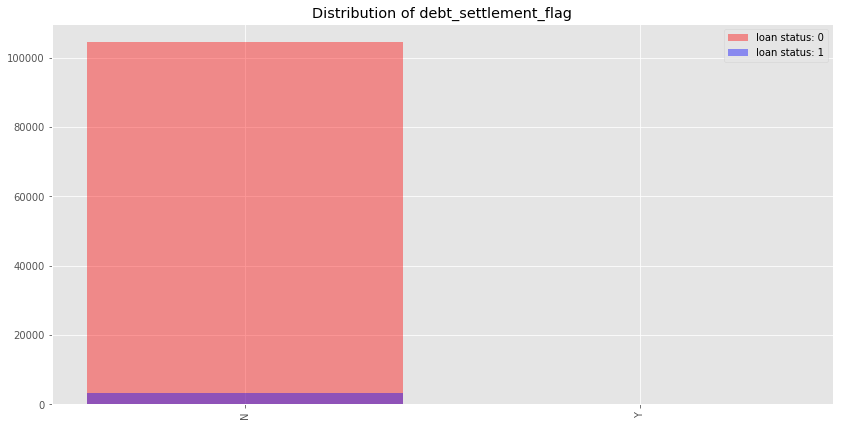

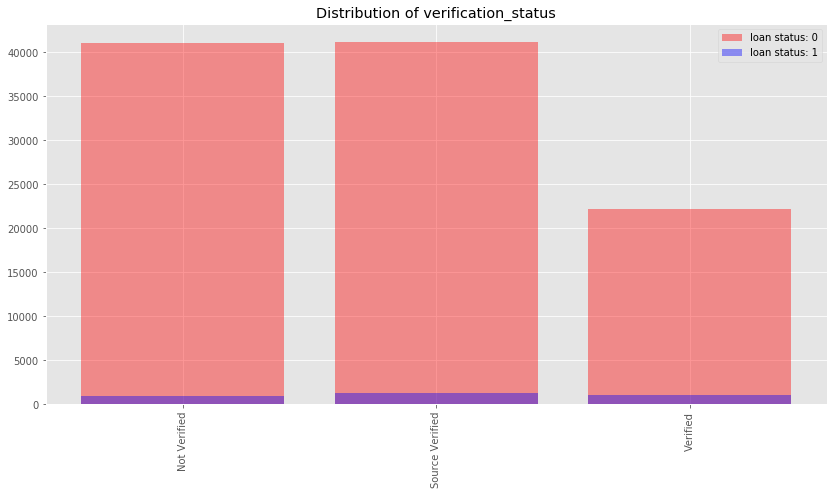

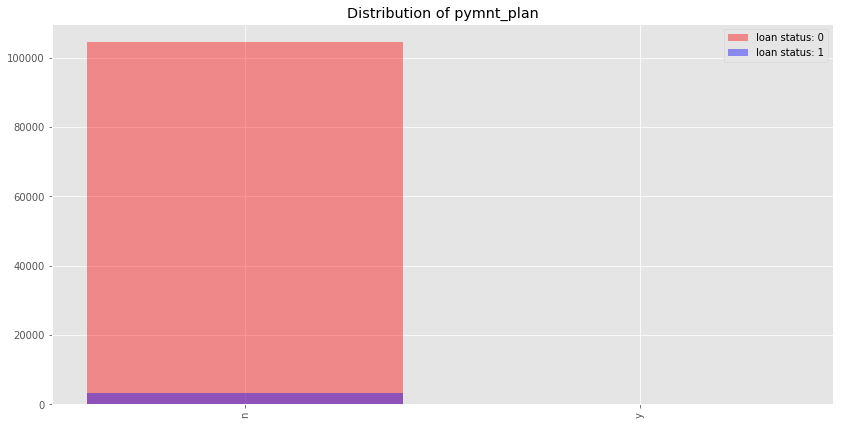

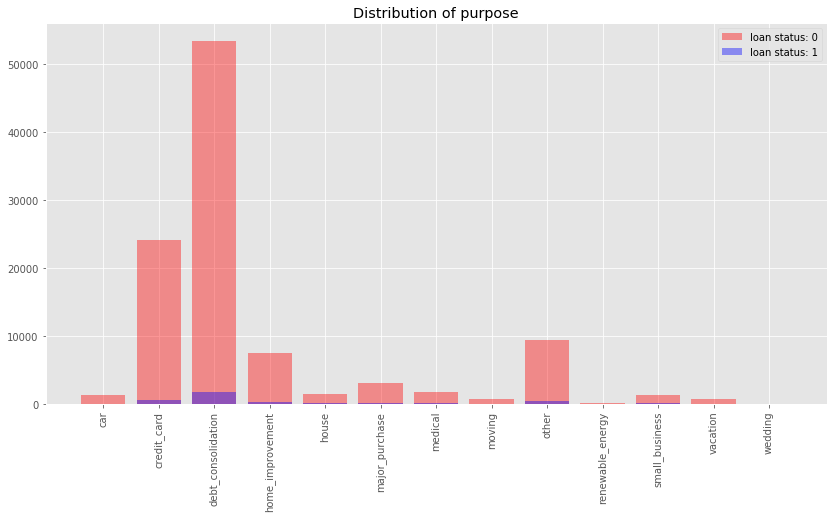

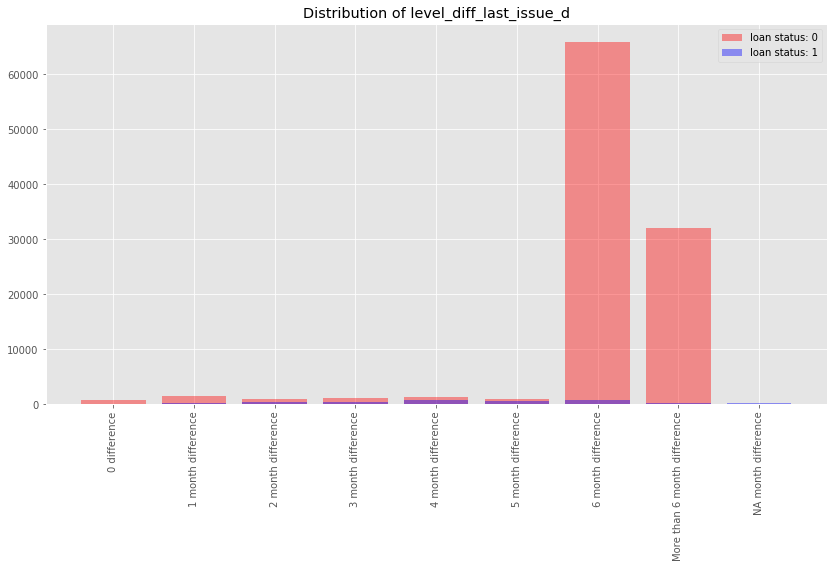

In [258]:
for each in tem_col_name:
    cate_feature_distribution_plot(each)

## 7. Save the final dataset into a csv file for a later model fitting operation

In [259]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,level_diff_last_issue_d,numeric_diff_next_issue_d,level_diff_next_issue_d,level_since_last_credit_pull,T_unique_title,days_since_issue,level_since_issue,days_between_max_issue_earliest_cr_line,level_between_max_issue_earliest_cr_line,group_state
0,7200.0,7200.0,7200.0,36 months,13.58,244.62,C,C2,8 years,RENT,...,6 month difference,184.0,6 month difference,Negative 4 mths,Other titles,0,0 mth,4748.0,14 yrs,west
1,12000.0,12000.0,12000.0,36 months,6.07,365.45,A,A2,10+ years,MORTGAGE,...,6 month difference,184.0,6 month difference,Negative 4 mths,president,0,0 mth,10286.0,35 yrs,northeast
2,3100.0,3100.0,3100.0,36 months,9.43,99.21,B,B1,10+ years,MORTGAGE,...,6 month difference,184.0,6 month difference,Negative 4 mths,manager,0,0 mth,6148.0,21 yrs,southeast
3,3200.0,3200.0,3200.0,36 months,7.96,100.22,A,A5,1 year,RENT,...,6 month difference,184.0,6 month difference,Negative 4 mths,Other titles,0,0 mth,1308.0,7 yrs,northeast
4,11000.0,11000.0,11000.0,36 months,7.34,341.37,A,A4,10+ years,OWN,...,6 month difference,184.0,6 month difference,Negative 4 mths,Other titles,0,0 mth,8491.0,28 yrs,west


In [260]:
loan.to_csv('../data/final_LC_loan.csv', encoding='utf-8', index=False)